# Classification of chess figures
* Data was downloaded using google images download
* The images consist of pawns, knights, bishops, rooks, queens and kings
* The images were taken from physical (wooden), digital and drawn chess boards

In [ ]:
!pip install git+https://github.com/UBod/pyMLaux.git

  Cloning https://github.com/UBod/pyMLaux.git to /tmp/pip-req-build-un838e3e
  Running command git clone --filter=blob:none --quiet https://github.com/UBod/pyMLaux.git /tmp/pip-req-build-un838e3e
  Resolved https://github.com/UBod/pyMLaux.git to commit fee8dfb366fcb0bfb9944a7ac714678aeb521c58
  Preparing metadata (setup.py) ... done
  Created wheel for pyMLaux: filename=pyMLaux-0.0.7-py3-none-any.whl size=6830 sha256=0d4e1abba8d8ae45dca30ed5cb64f35add8bfa2d6a4867c3fc07936e29152405
  Stored in directory: /tmp/pip-ephem-wheel-cache-6x87iurz/wheels/53/7c/8e/707f45969871484f44ca858446dfdb44bc59698484796806c1
Successfully built pyMLaux


In [ ]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

from pyMLaux import plot_history, read_MNIST, show_img_data,  show_img, evaluate_classification_result, create_data_from_testimage

In [ ]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.1
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/MyDrive/'
notebook_dir = base_dir + 'Colab\ Notebooks/'
data_dir = base_dir + 'Colab Notebooks/ImageData/'

# Task 1: Split training and validation data (test data comes later)

In [ ]:
train_dir = data_dir + "Chess"

IMG_HEIGHT, IMG_WIDTH = 224, 224
batch_size = 32

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           subset="training",
                                                           class_mode='categorical')

val_data_gen = train_image_generator.flow_from_directory( batch_size=batch_size,
                                                          directory=train_dir,
                                                          shuffle=True,
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                          subset="validation",
                                                          class_mode='categorical')


Found 469 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


In [ ]:
print(train_data_gen.class_indices)

{'Bishop': 0, 'King': 1, 'Knight': 2, 'Pawn': 3, 'Queen': 4, 'Rook': 5}


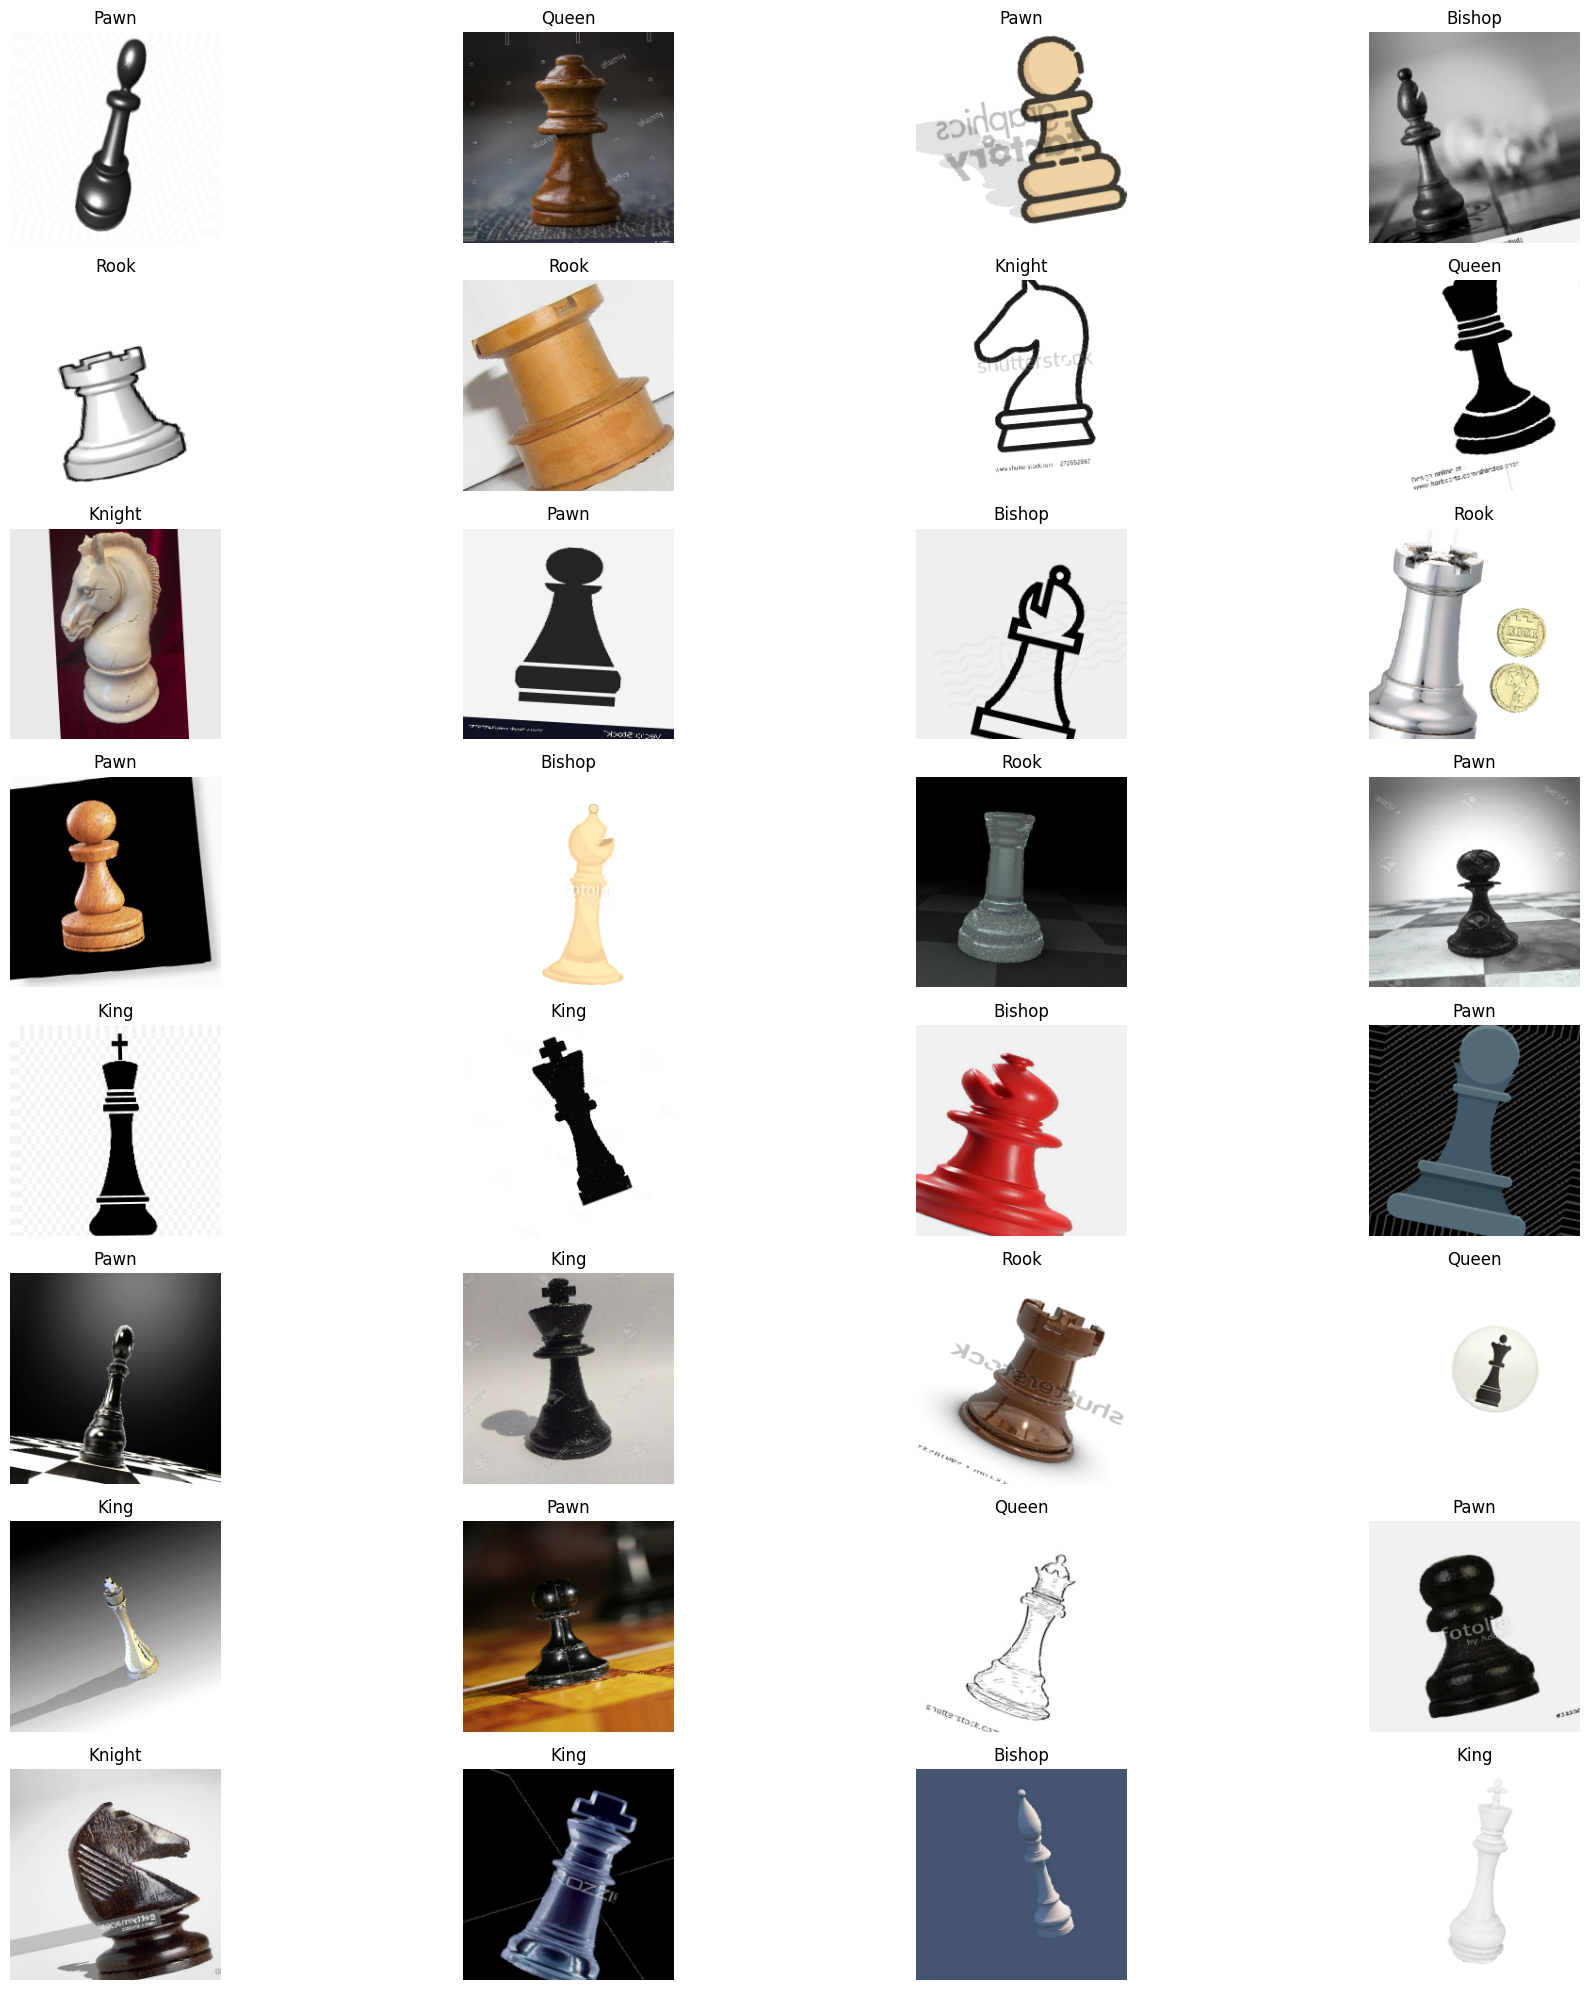

In [ ]:
sample_training_images, labels = next(train_data_gen)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

# Task 2: Implementation of some CNN

In [ ]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(
        include_top=False,
        pooling='max',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        weights='imagenet')

94668760/94668760 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

history = model.fit(
  skip_broken_images(train_data_gen),
  validation_data=val_data_gen,
  steps_per_epoch=12, #use way more steps here: number of samples / batch size
  epochs=500, #use way more or use EarlyStopping callback
  #callbacks=[snapshot_callback]
)

Epoch 1/500
12/12 [==============================] - 41s 1s/step - loss: 8.3556 - categorical_accuracy: 0.1875 - val_loss: 5.8017 - val_categorical_accuracy: 0.2000
Epoch 2/500
12/12 [==============================] - 12s 1s/step - loss: 2.4640 - categorical_accuracy: 0.1609 - val_loss: 14.2883 - val_categorical_accuracy: 0.2400
Epoch 3/500
12/12 [==============================] - 10s 877ms/step - loss: 2.1330 - categorical_accuracy: 0.1501 - val_loss: 10.7867 - val_categorical_accuracy: 0.1800
Epoch 4/500
12/12 [==============================] - 13s 1s/step - loss: 1.9991 - categorical_accuracy: 0.1635 - val_loss: 4.2766 - val_categorical_accuracy: 0.2200
Epoch 5/500
12/12 [==============================] - 11s 993ms/step - loss: 1.8618 - categorical_accuracy: 0.1716 - val_loss: 4.1172 - val_categorical_accuracy: 0.2000
Epoch 6/500
12/12 [==============================] - 11s 980ms/step - loss: 1.8219 - categorical_accuracy: 0.1745 - val_loss: 5.2615 - val_categorical_accuracy: 0.1800

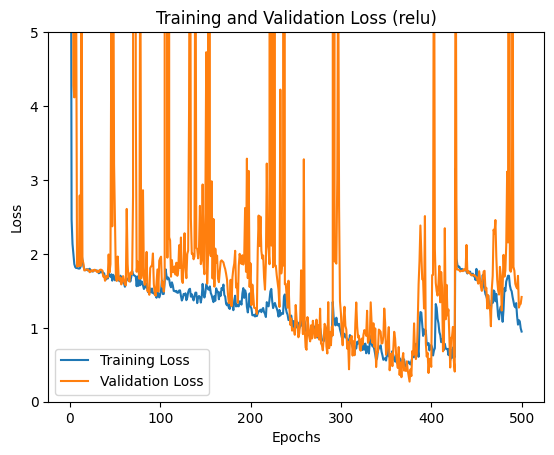

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
# Plotting the training and validation loss
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
ax = plt.gca()
ax.set_ylim([0, 5])
plt.title('Training and Validation Loss (relu)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            pass

In [ ]:
def print_loss(history, function_name):
  # Extract training and validation loss from the history object
  training_loss = history.history['loss']
  validation_loss = history.history['val_loss']

  # Plotting the training and validation loss
  epochs = range(1, len(training_loss) + 1)

  plt.plot(epochs, training_loss, label='Training Loss')
  plt.plot(epochs, validation_loss, label='Validation Loss')
  plt.title('Training and Validation Loss (' + function_name + ')')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

Task 3: Perform some Experiment (Here many different activation functions are tested)

In [ ]:
activation_functions = ['relu', 'sigmoid', 'tanh', 'selu', 'elu', 'exponential',
                        'leaky_relu', 'silu', 'gelu', 'hard_sigmoid',
                        'linear', 'mish']

Task 4: Execute and monitor training

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

models = []

for activation_function in activation_functions:
  model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(256, activation_function),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation_function),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation_function),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation_function),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
  ])

  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

  history = model.fit(
    skip_broken_images(train_data_gen),
    validation_data=val_data_gen,
    steps_per_epoch=12, #use way more steps here: number of samples / batch size
    epochs=100, #use way more or use EarlyStopping callback
    #callbacks=[snapshot_callback]
  )

  models.append((activation_function, model, history))



Epoch 1/100
12/12 [==============================] - 94s 7s/step - loss: 11.3083 - categorical_accuracy: 0.1536 - val_loss: 1.9225 - val_categorical_accuracy: 0.2800
Epoch 2/100
12/12 [==============================] - 10s 886ms/step - loss: 4.0143 - categorical_accuracy: 0.2225 - val_loss: 1.7523 - val_categorical_accuracy: 0.1200
Epoch 3/100
12/12 [==============================] - 9s 804ms/step - loss: 2.0287 - categorical_accuracy: 0.1769 - val_loss: 1.7683 - val_categorical_accuracy: 0.2600
Epoch 4/100
12/12 [==============================] - 11s 987ms/step - loss: 1.8361 - categorical_accuracy: 0.2225 - val_loss: 1.7717 - val_categorical_accuracy: 0.2600
Epoch 5/100
12/12 [==============================] - 8s 728ms/step - loss: 1.8334 - categorical_accuracy: 0.1743 - val_loss: 1.7857 - val_categorical_accuracy: 0.2600
Epoch 6/100
12/12 [==============================] - 12s 1s/step - loss: 1.7717 - categorical_accuracy: 0.2135 - val_loss: 1.7859 - val_categorical_accuracy: 0.2200

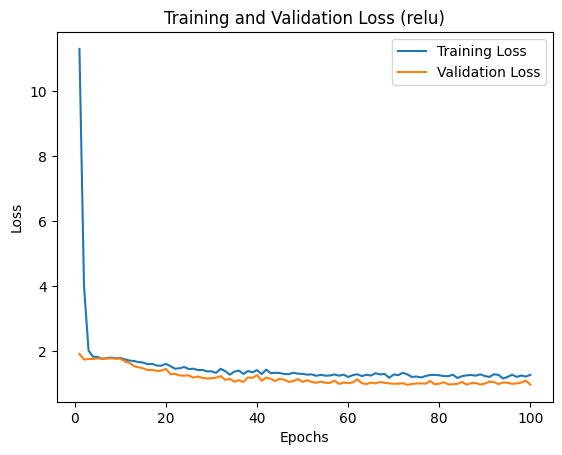

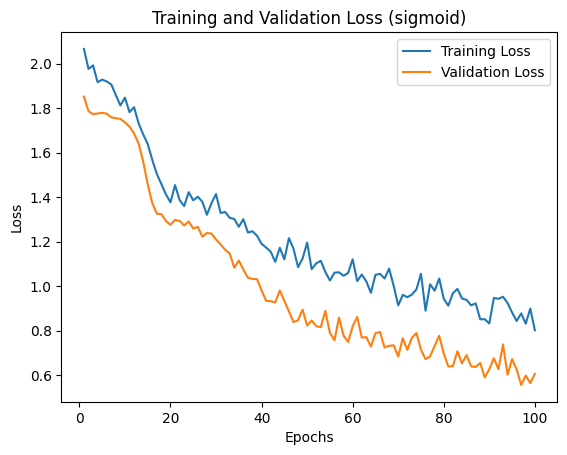

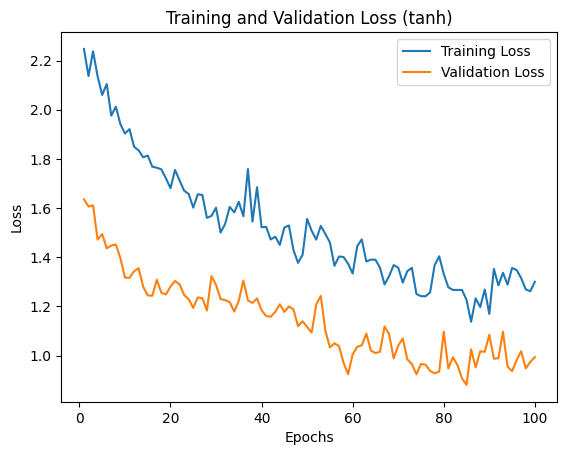

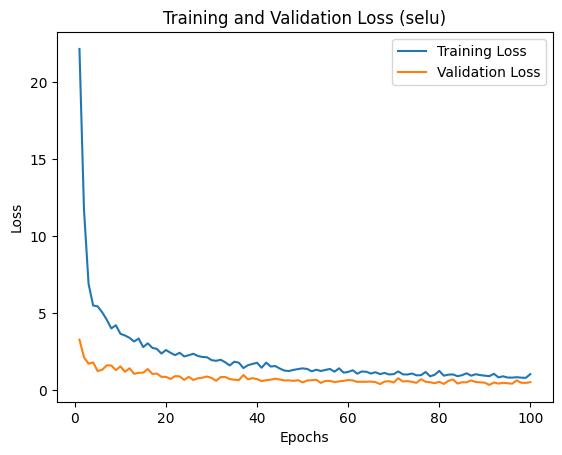

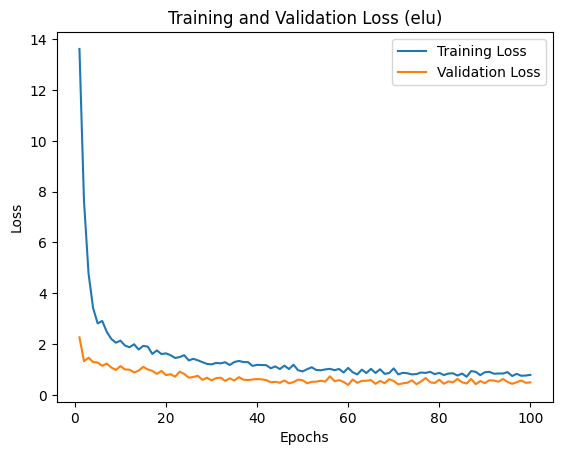

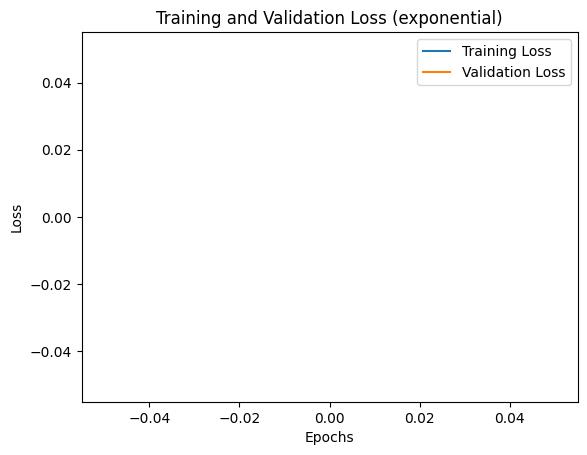

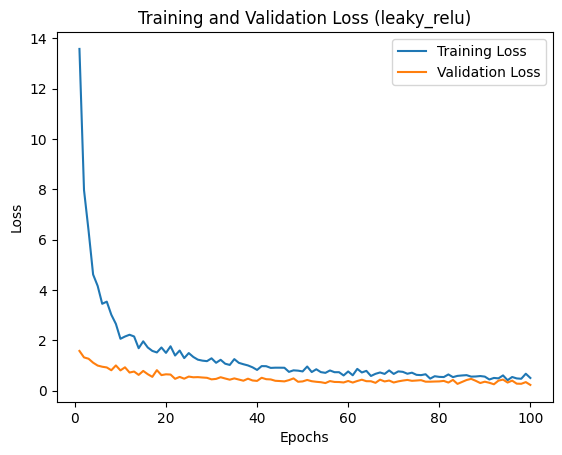

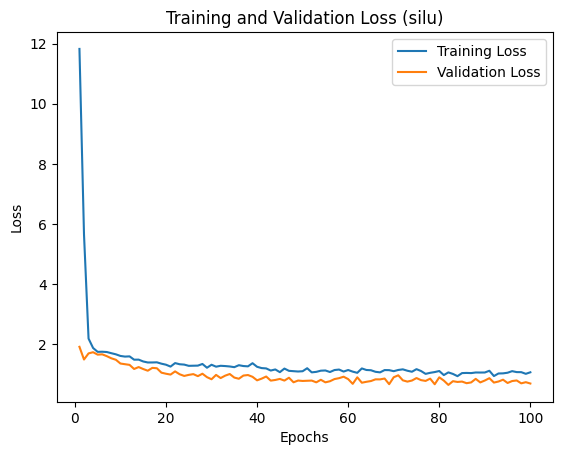

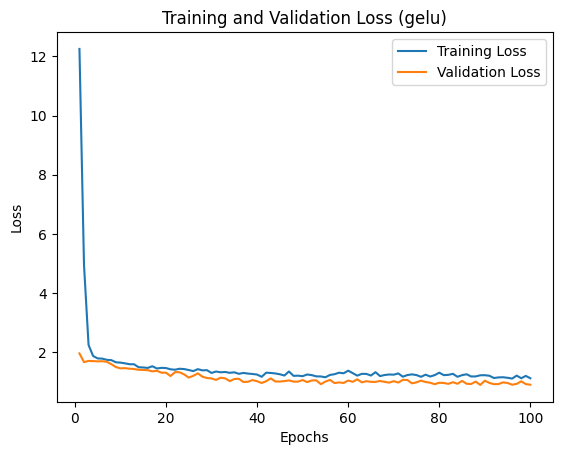

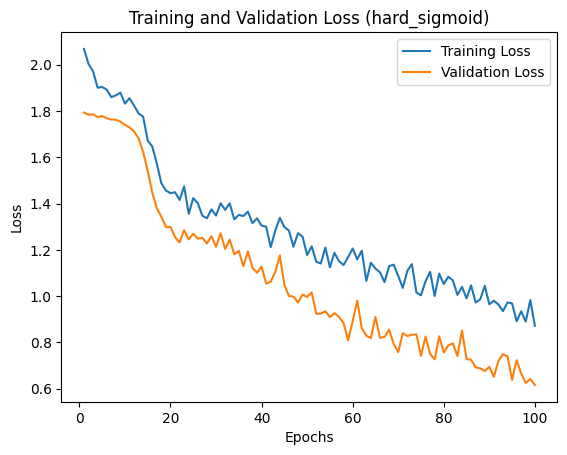

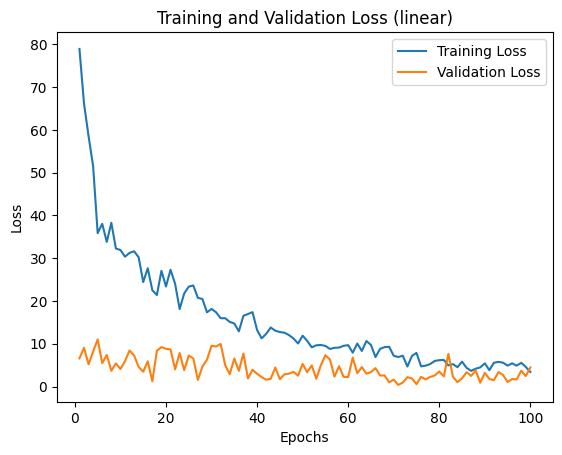

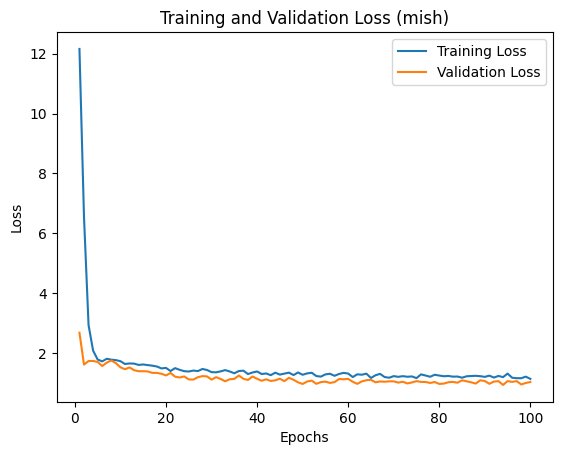

In [ ]:
for model in models:
  print_loss(model[2], model[0])

In [ ]:
# Function to convert class index to class name (adjust as needed)
def get_class_name(index):
    # Add your class names here
    class_names = ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']
    return class_names[index]

Task 5: Define some evaluation metric (Here AUC is used)

Task 6: Evaluation each experiment on validation set

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


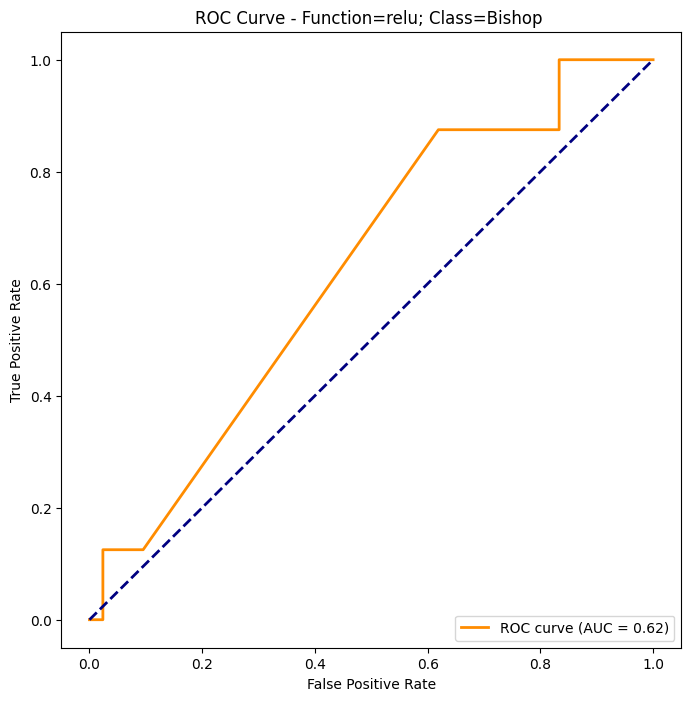

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


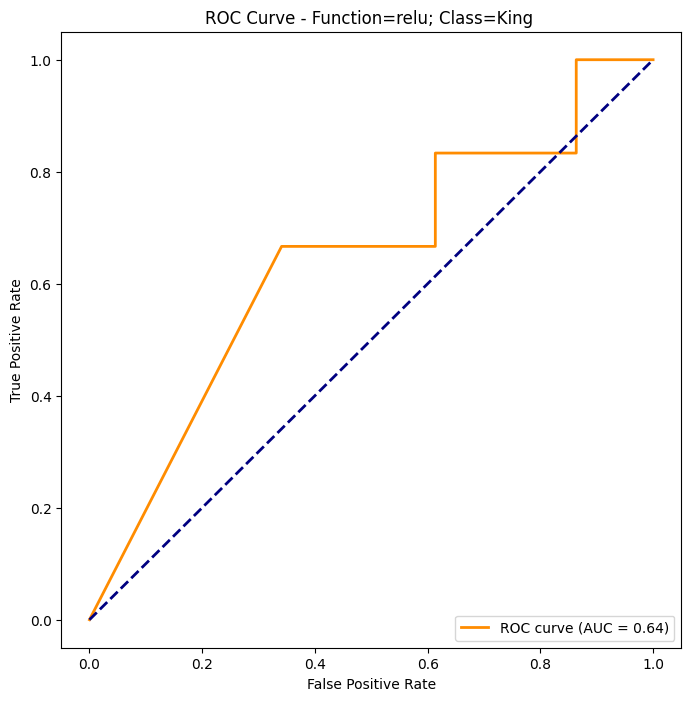

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


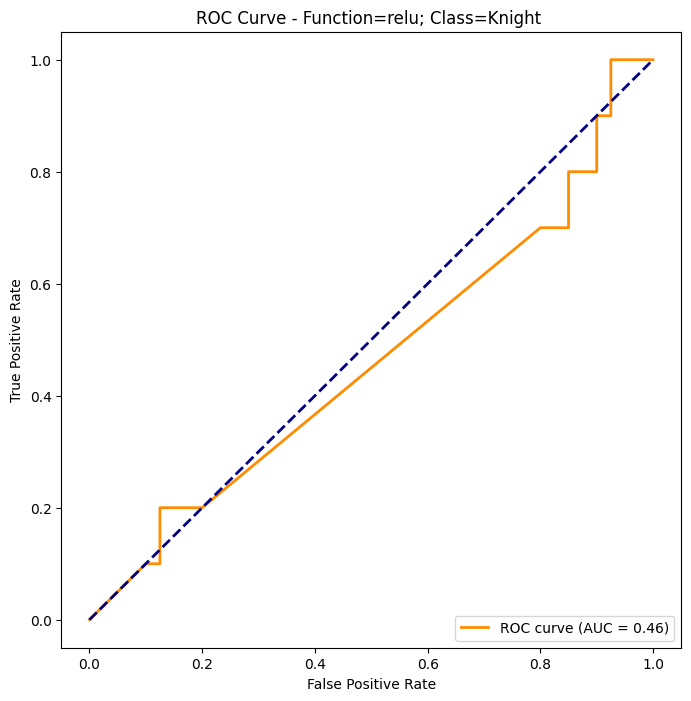

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


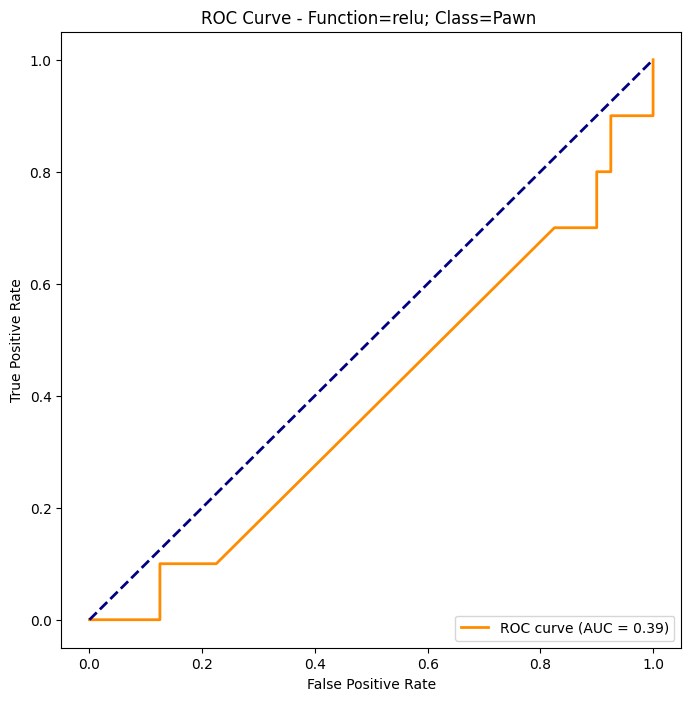

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


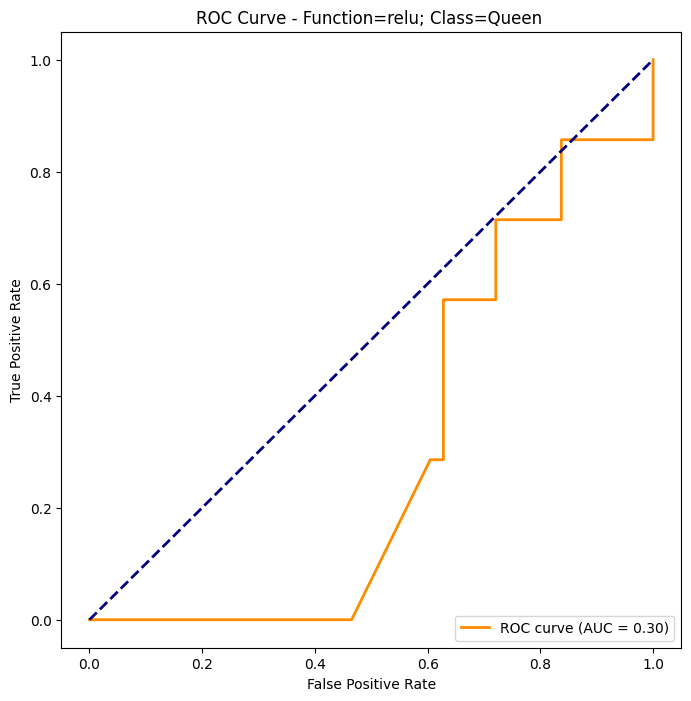

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


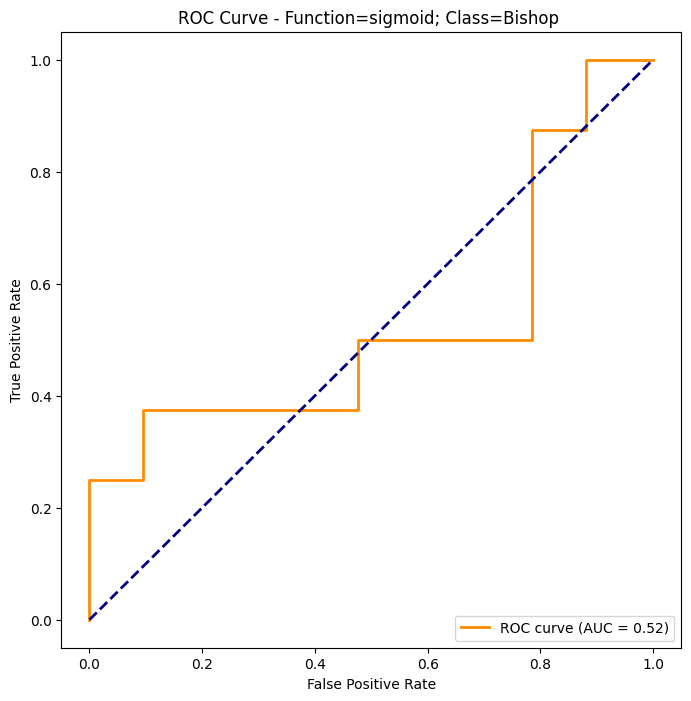

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


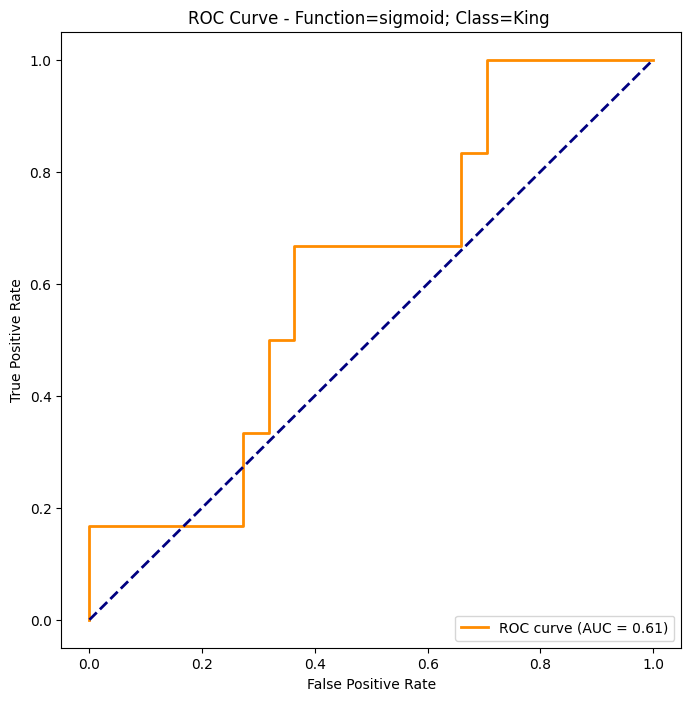

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


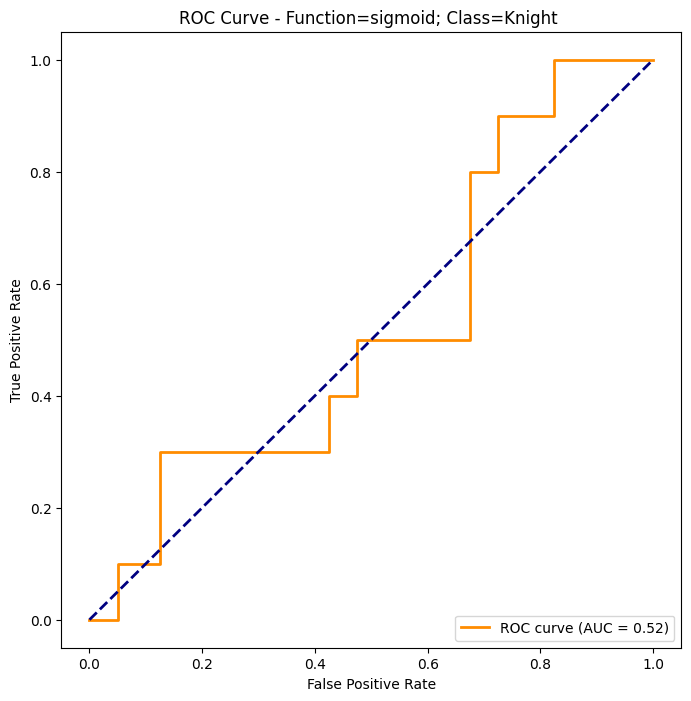

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


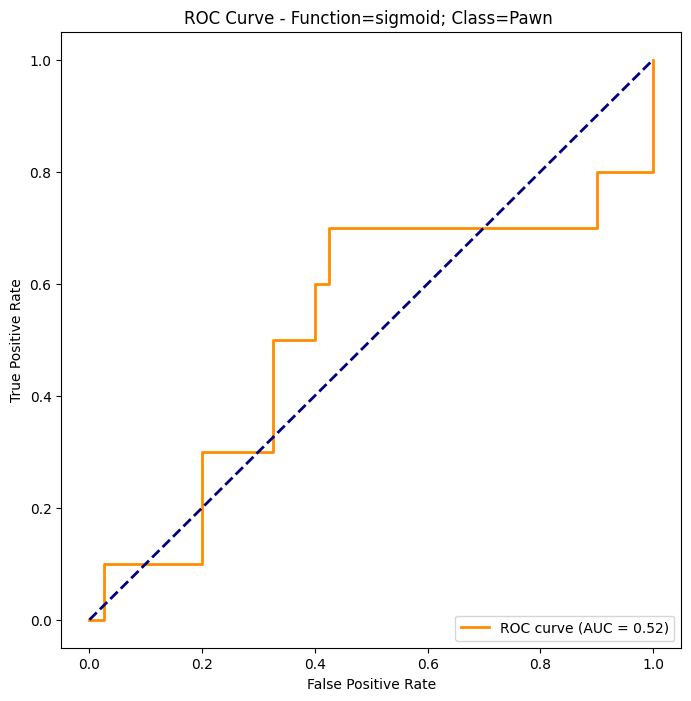

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


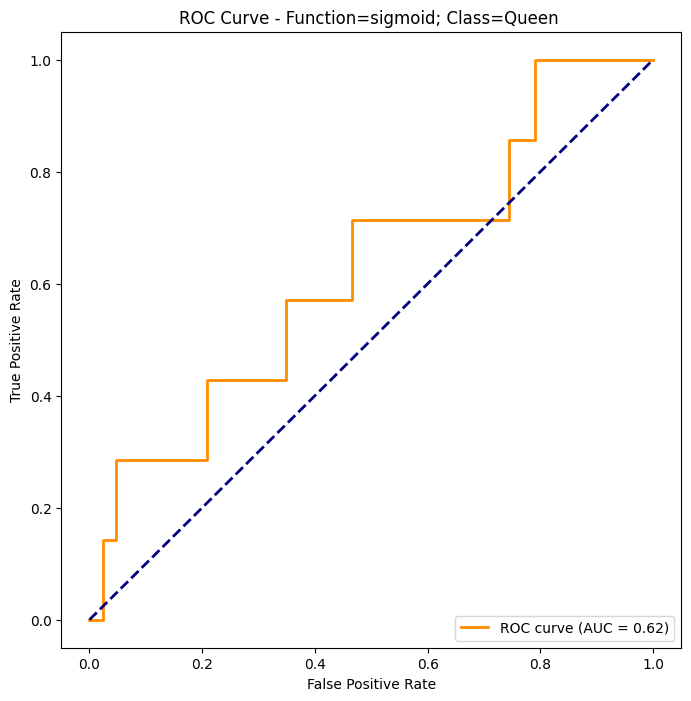

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


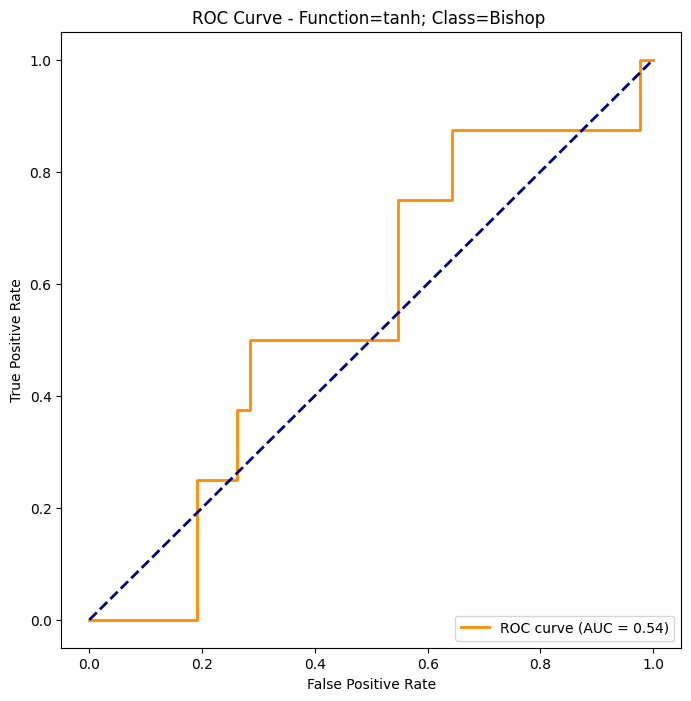

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


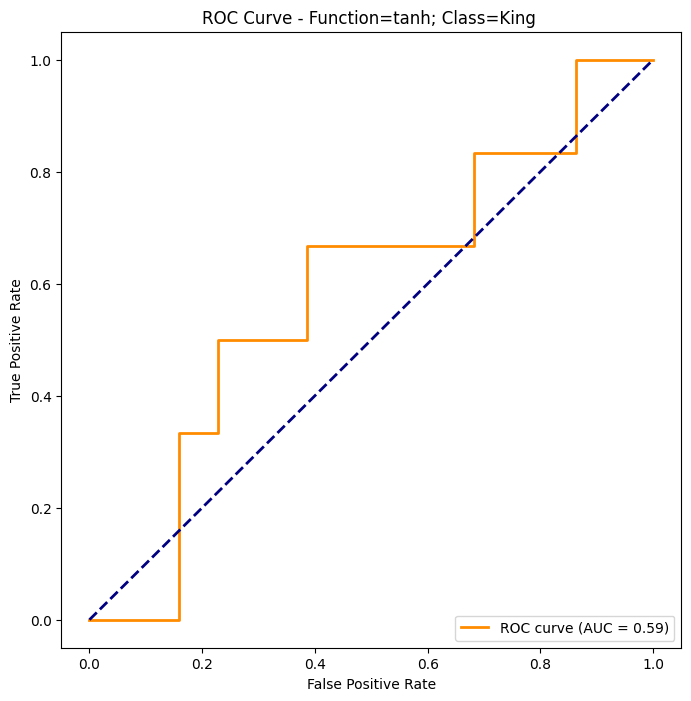

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


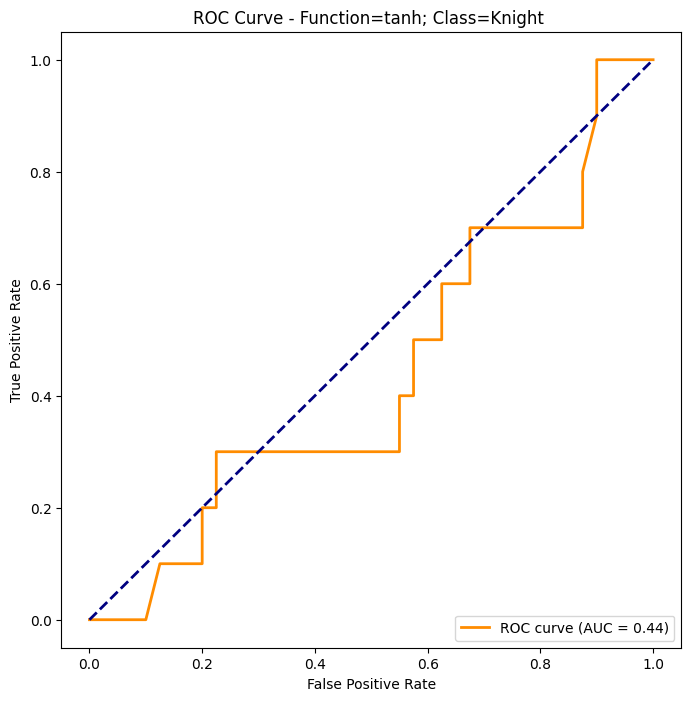

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


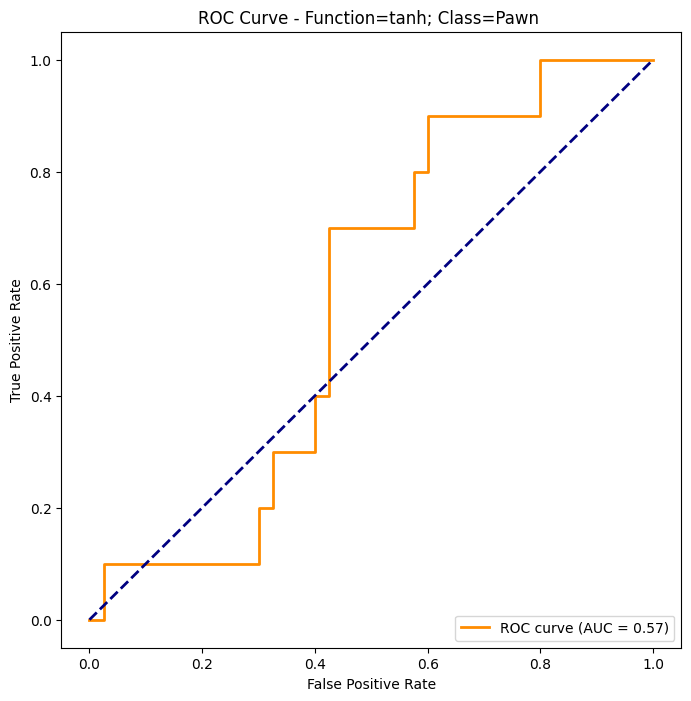

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


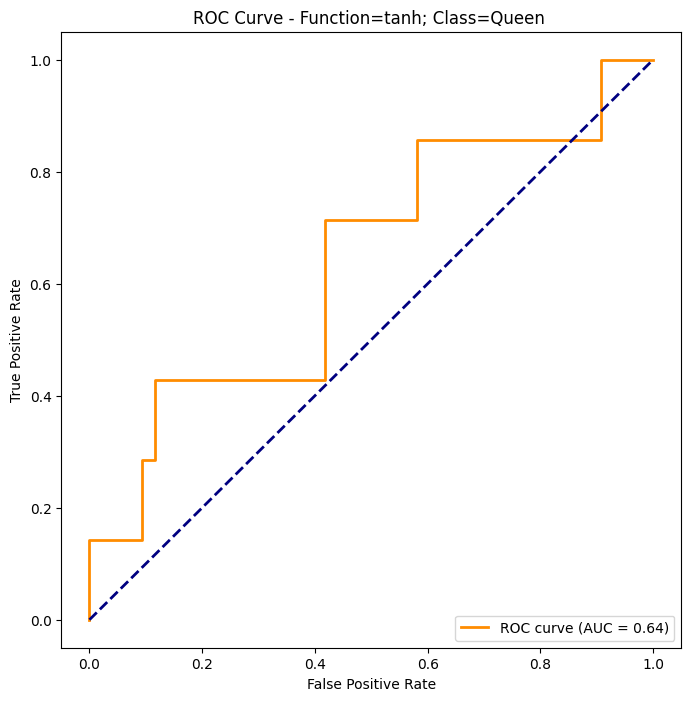

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


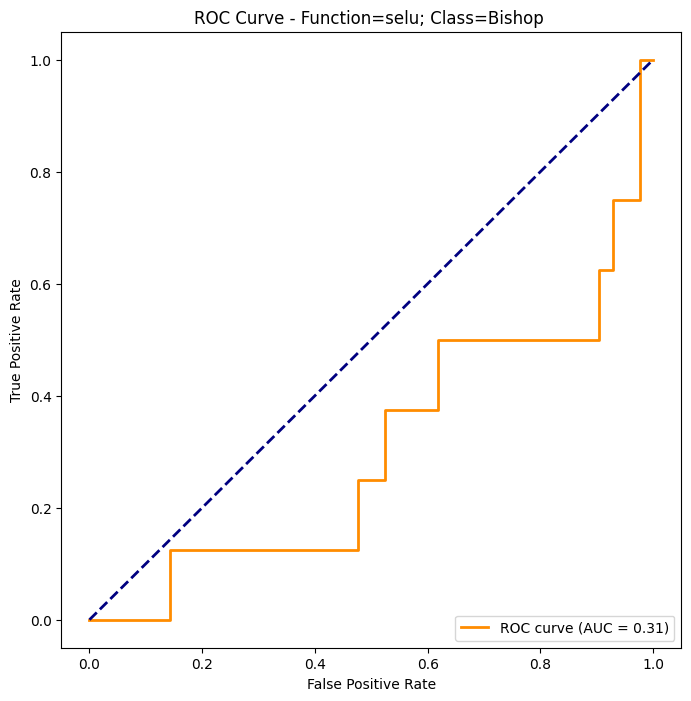

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


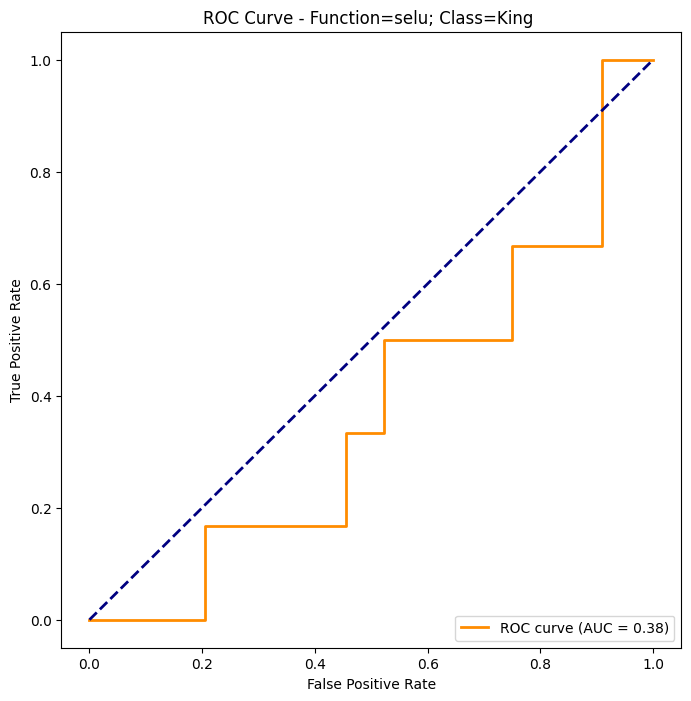

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


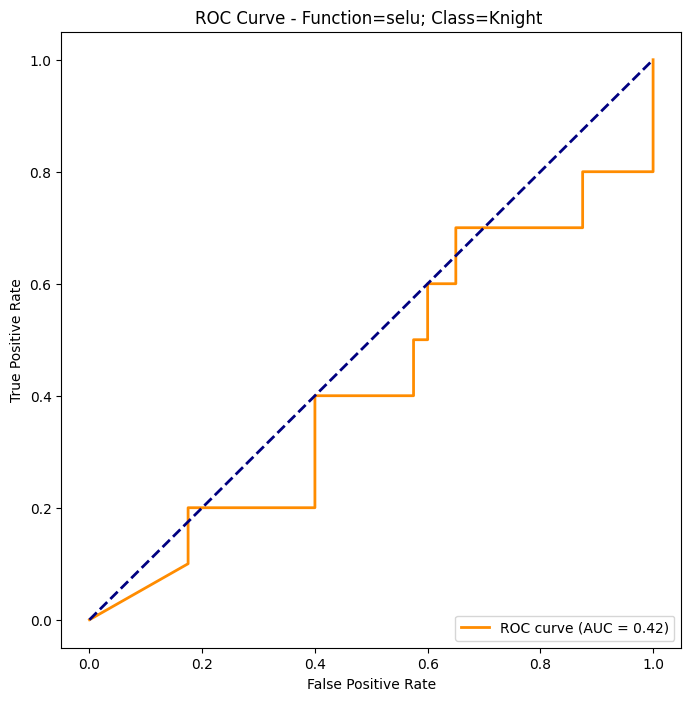

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


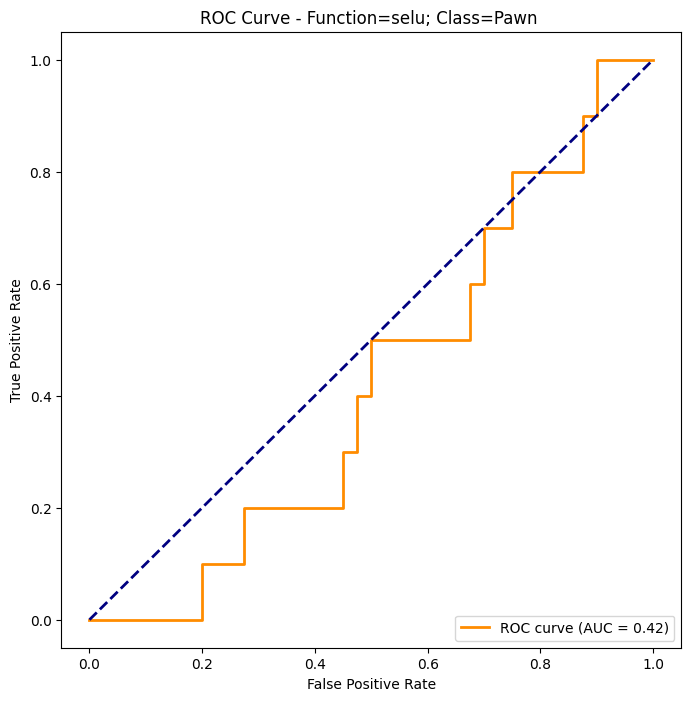

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


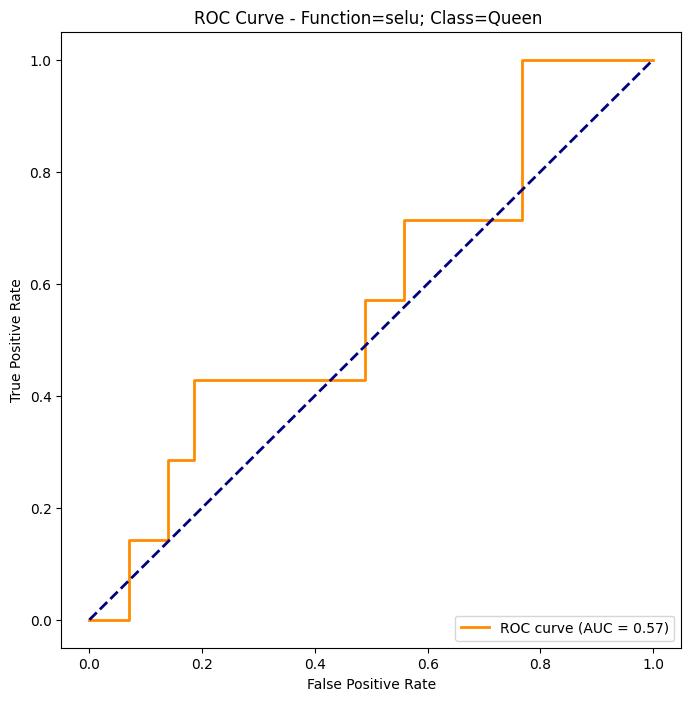

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


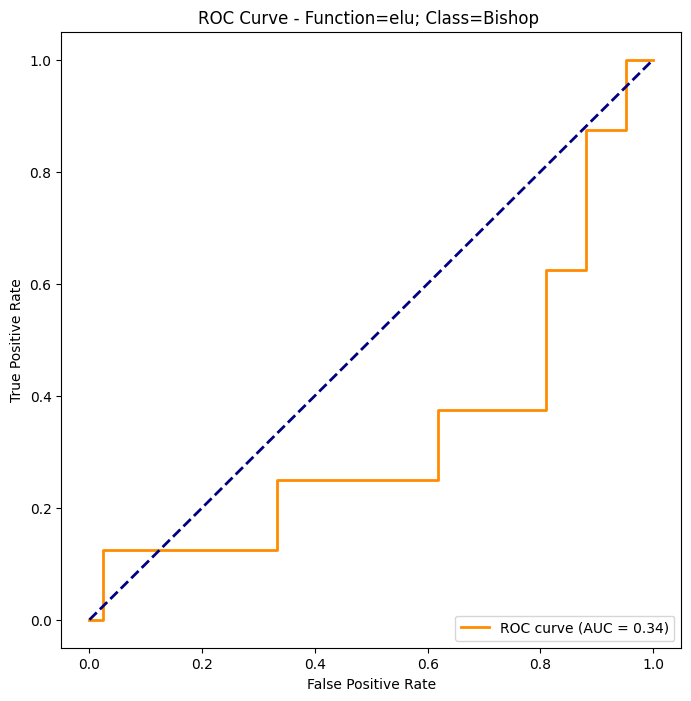

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


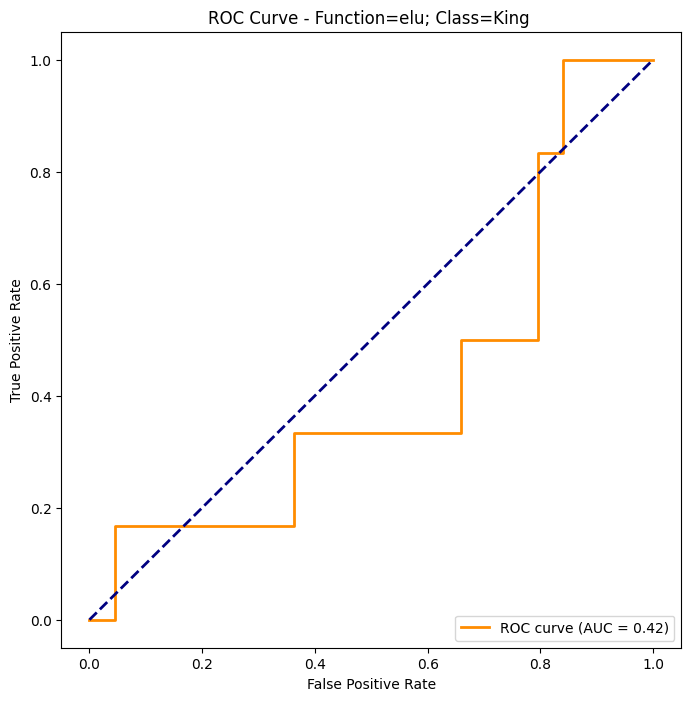

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


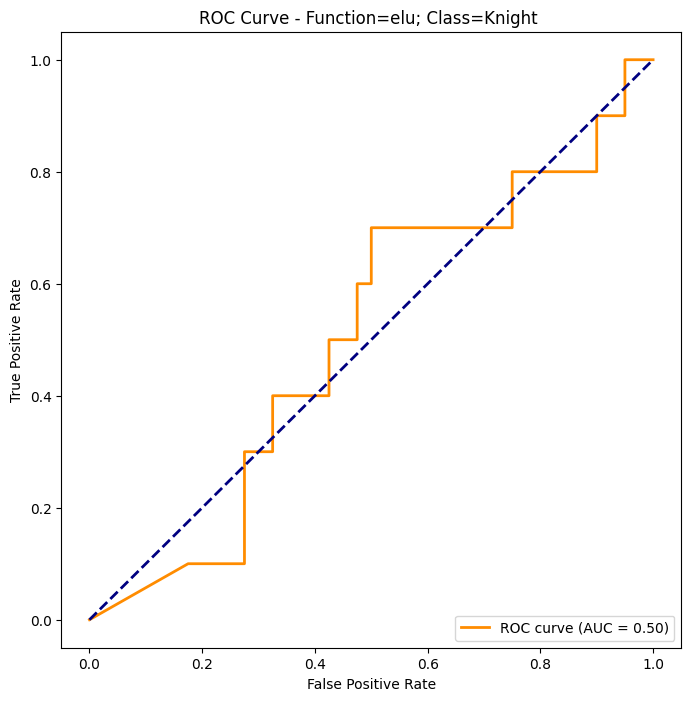

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


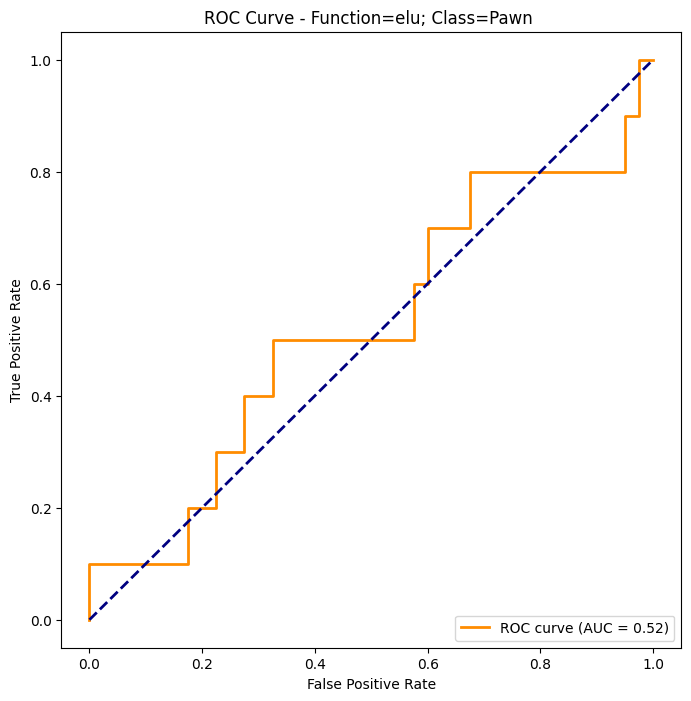

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


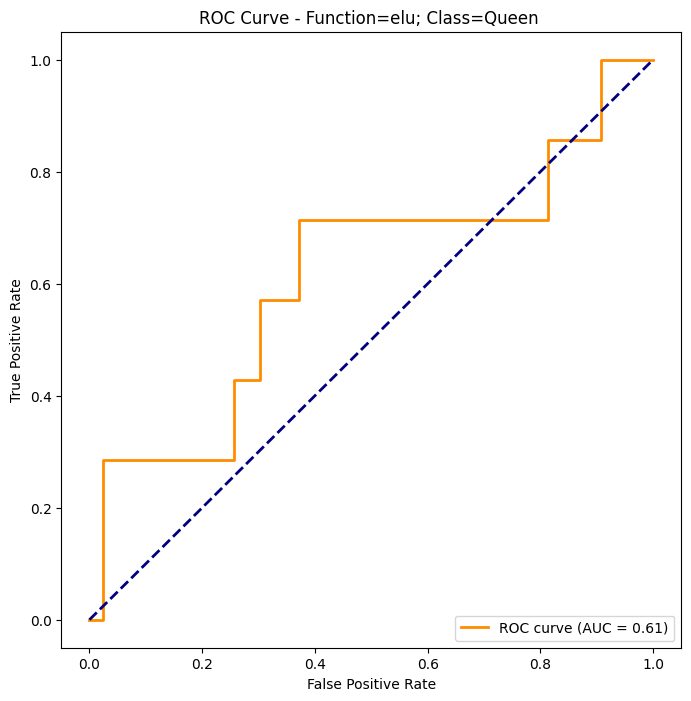

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


Input contained NaN


<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


Input contained NaN


<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


Input contained NaN


<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


Input contained NaN


<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


Input contained NaN


<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


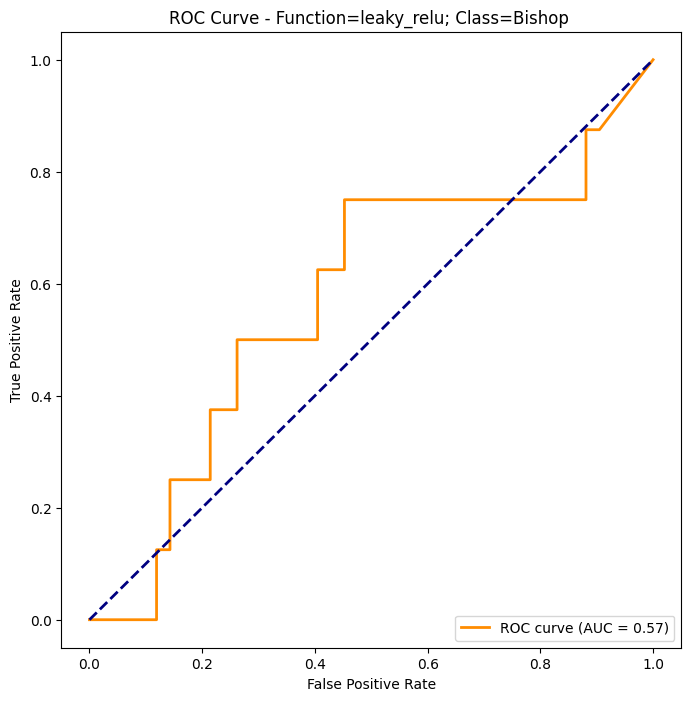

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


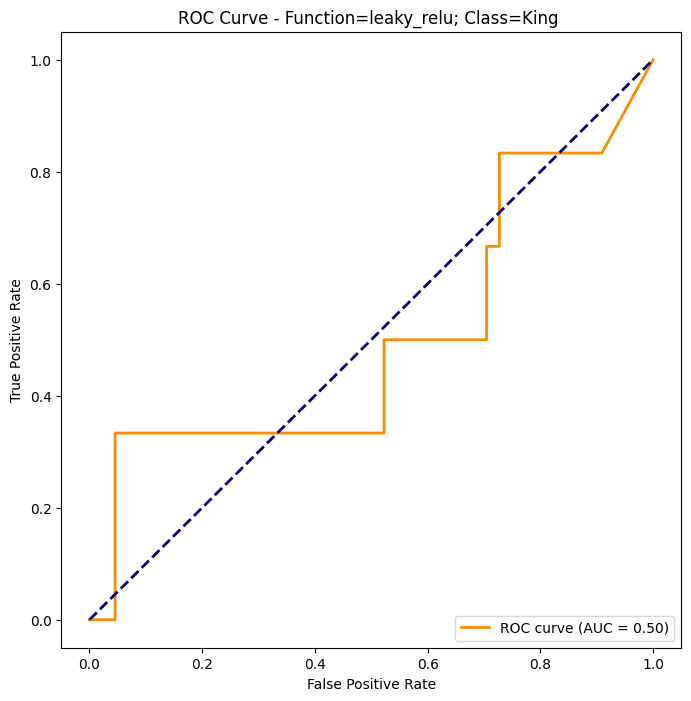

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


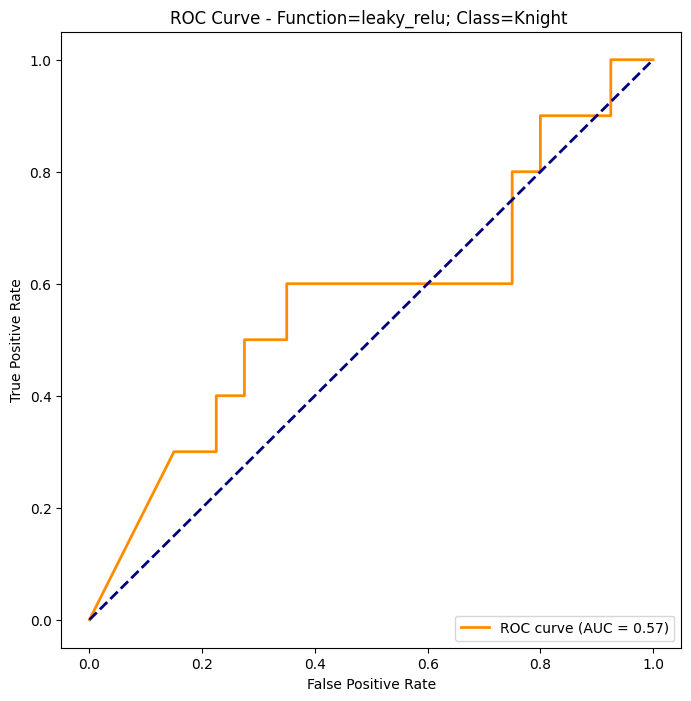

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


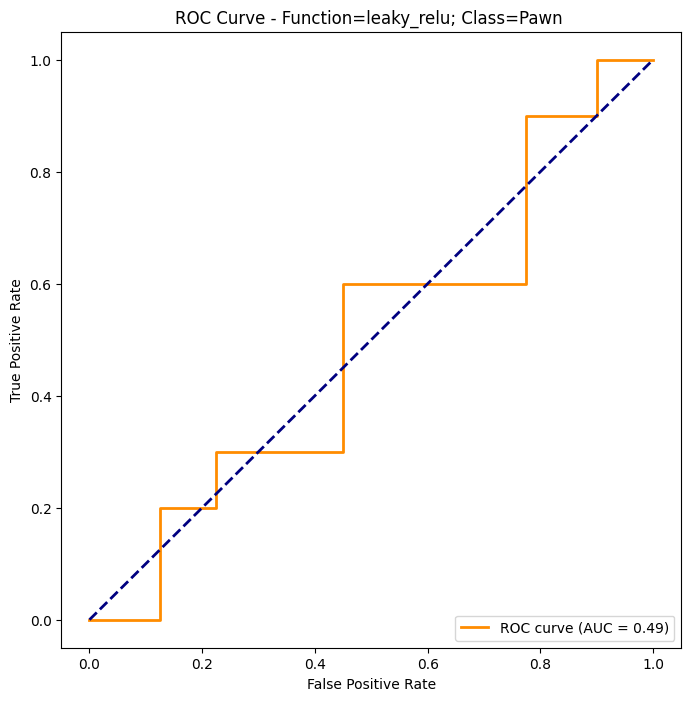

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


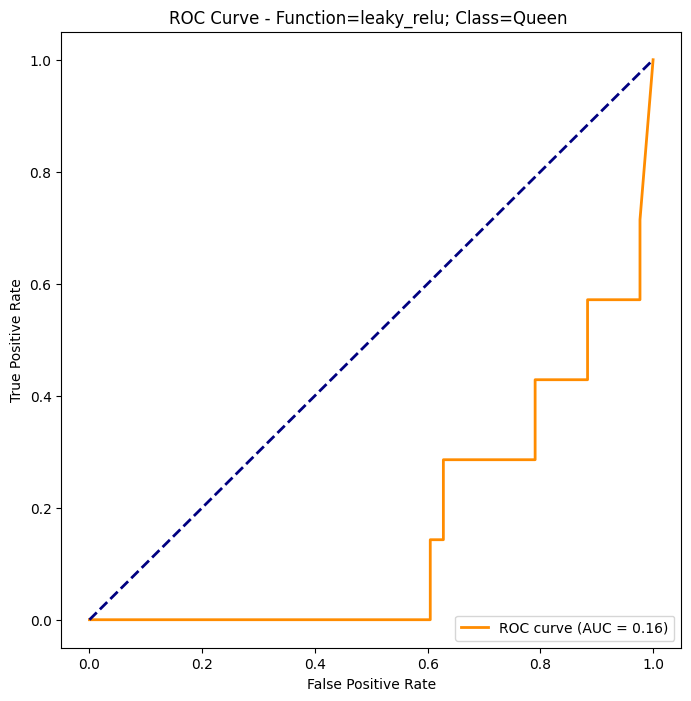

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


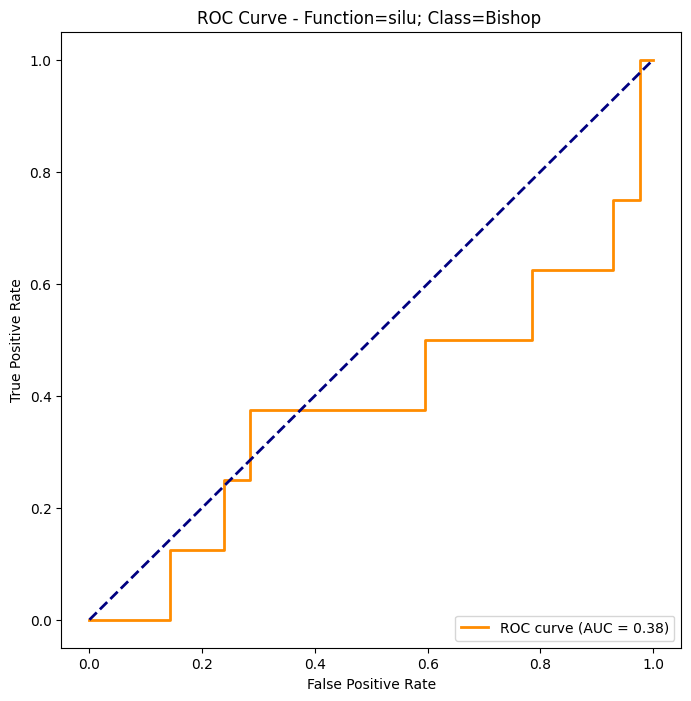

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


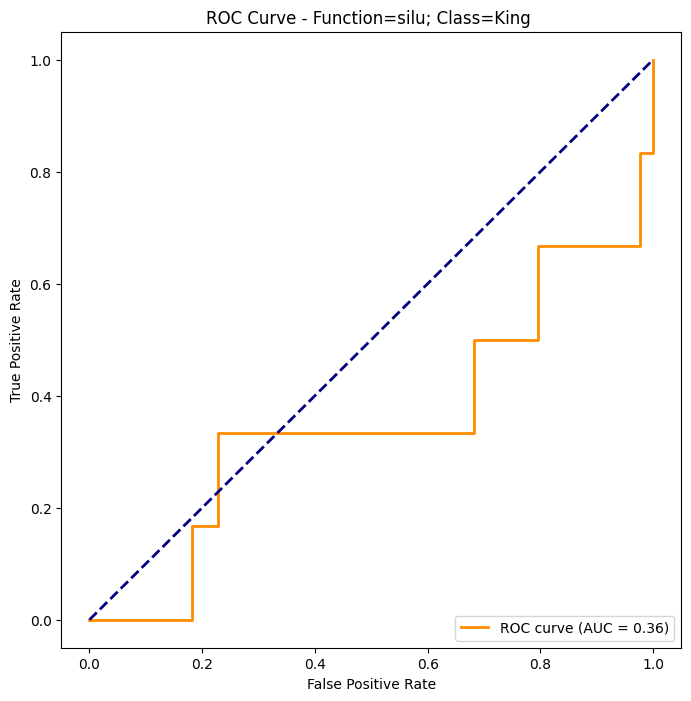

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


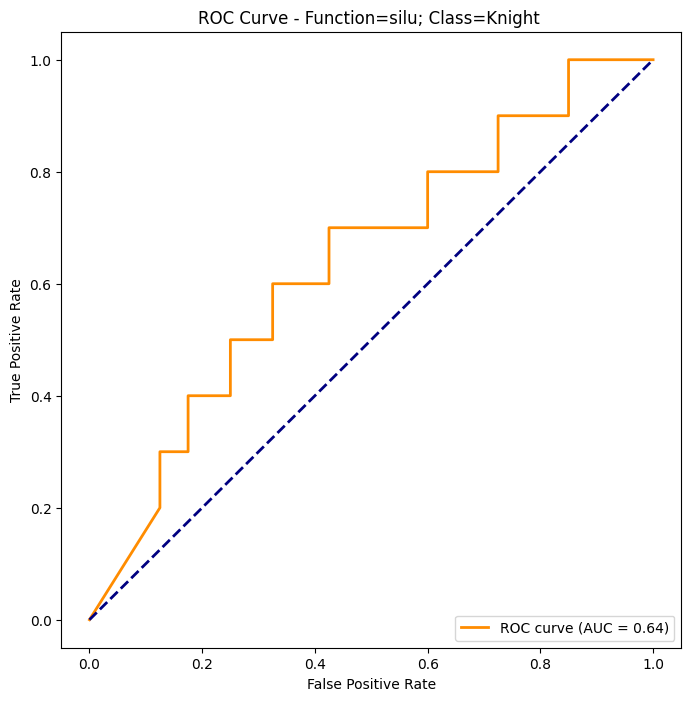

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


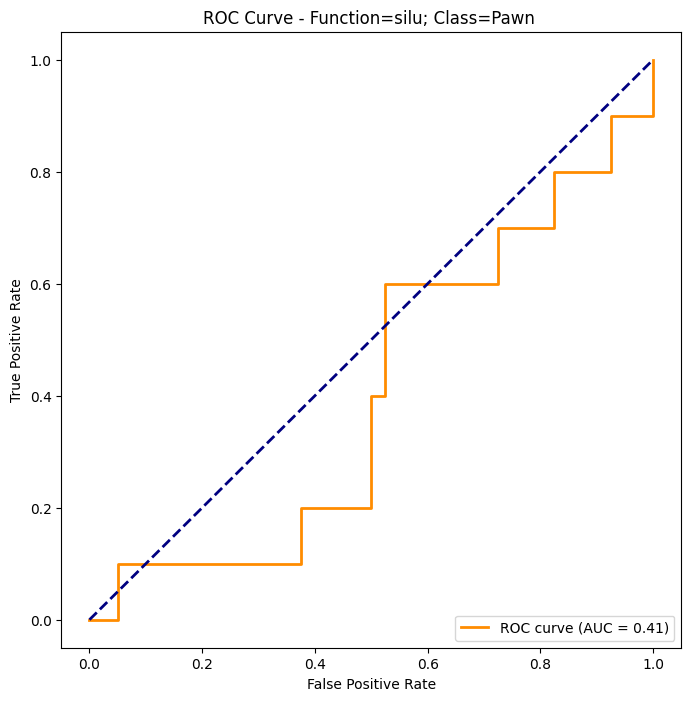

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


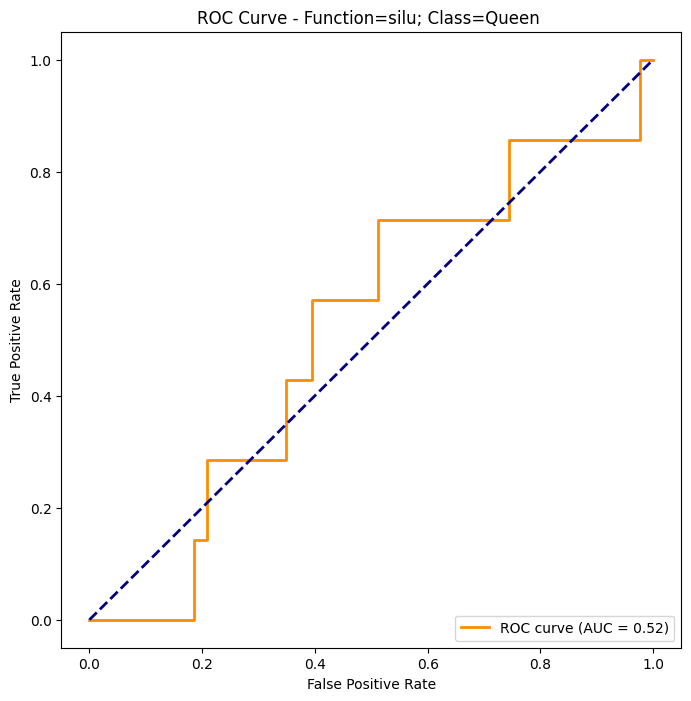

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


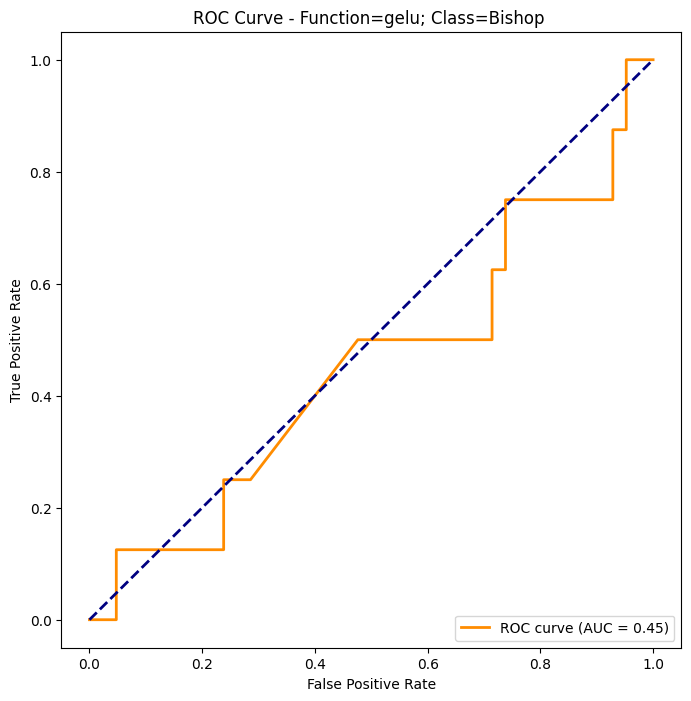

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


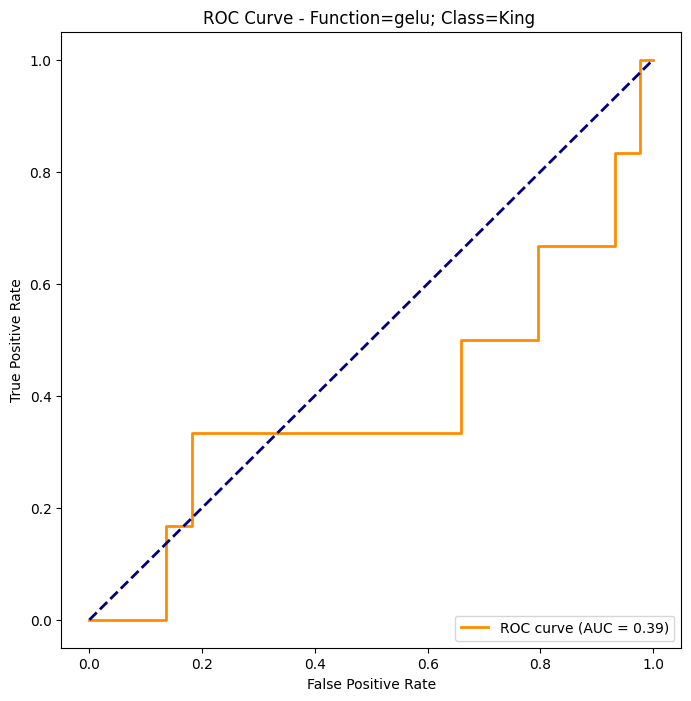

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


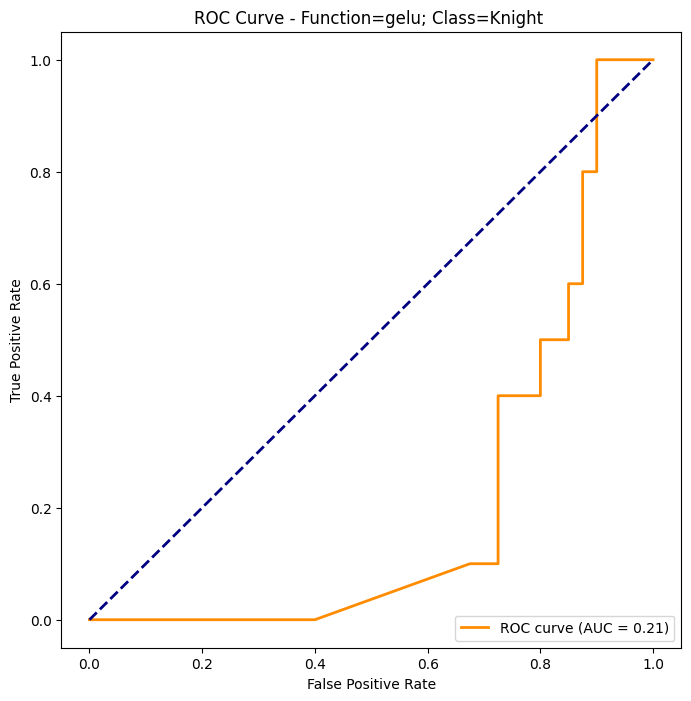

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


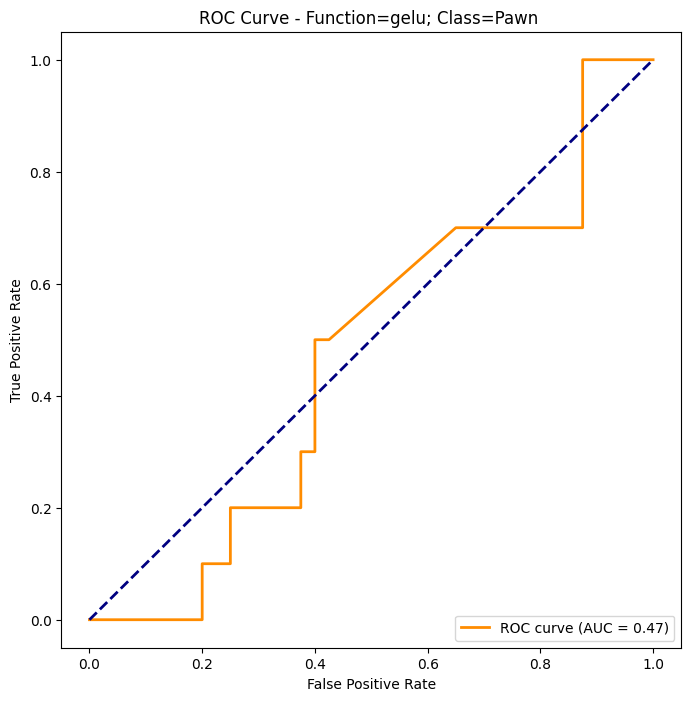

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


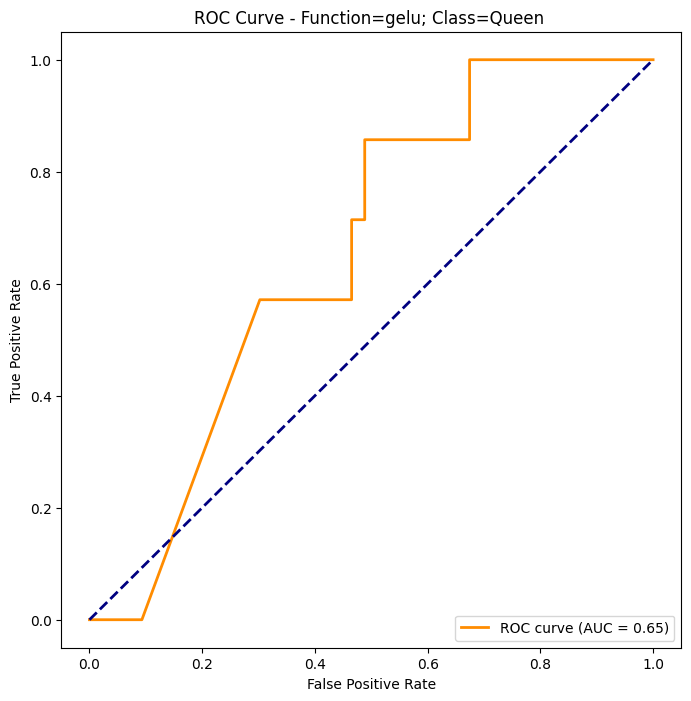

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


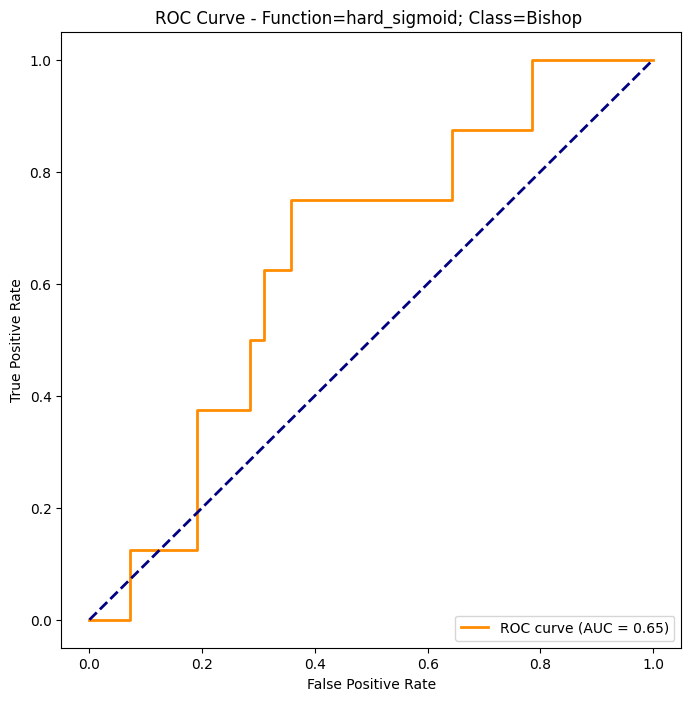

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


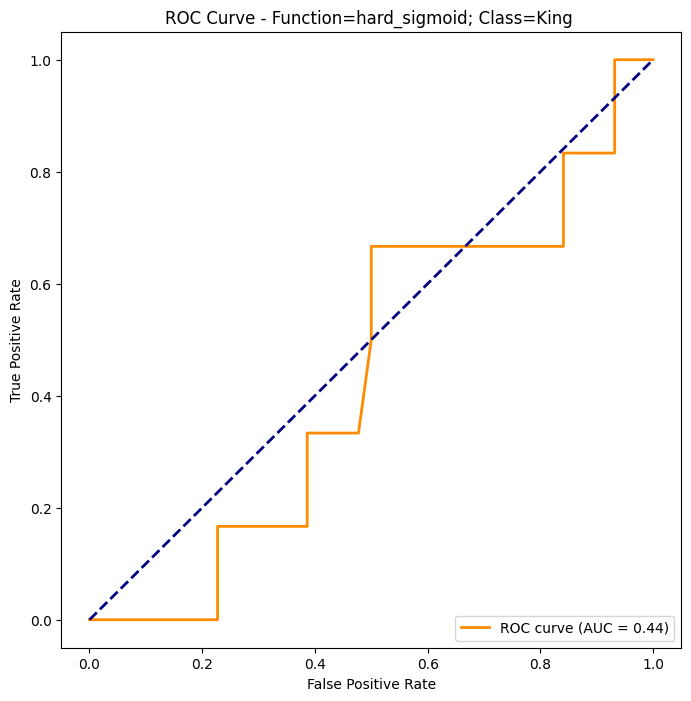

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


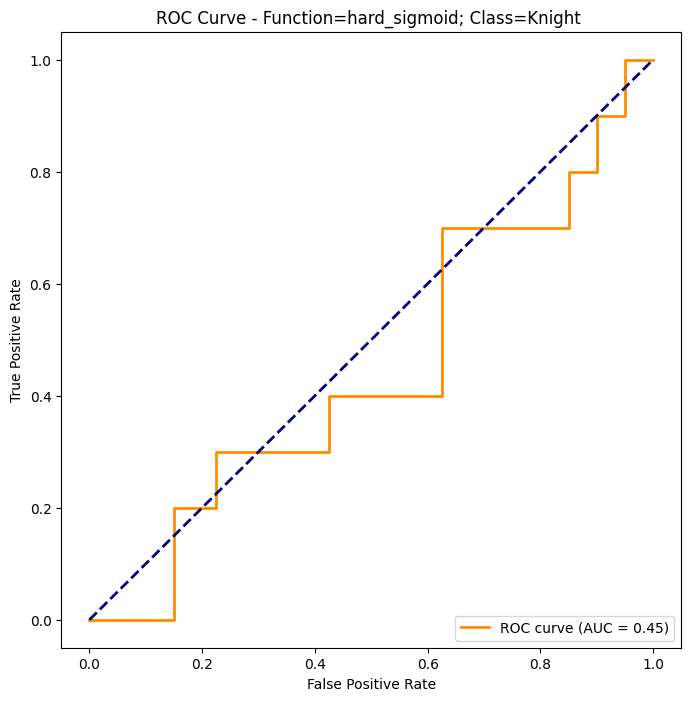

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


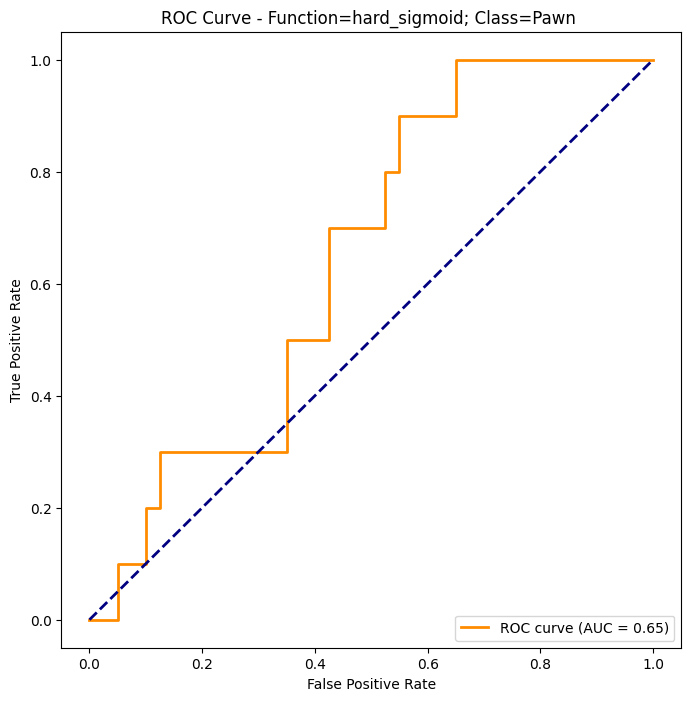

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


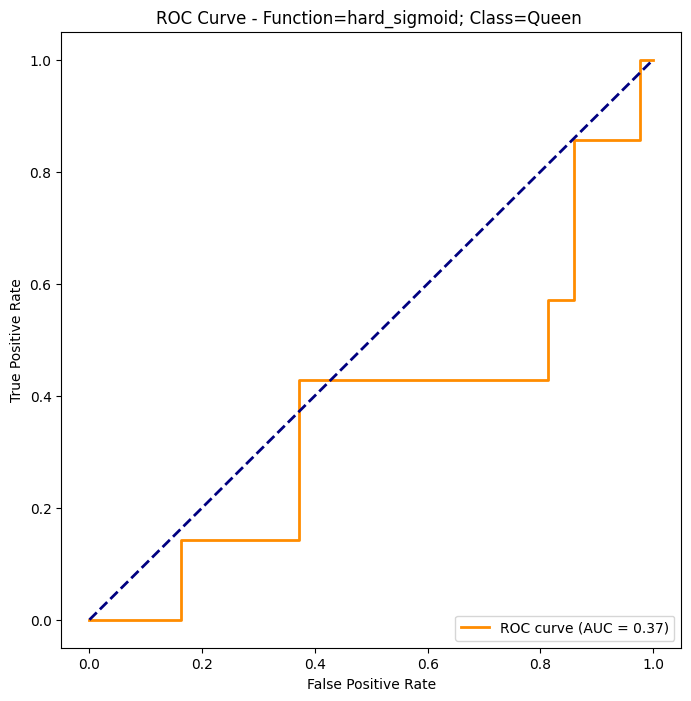

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


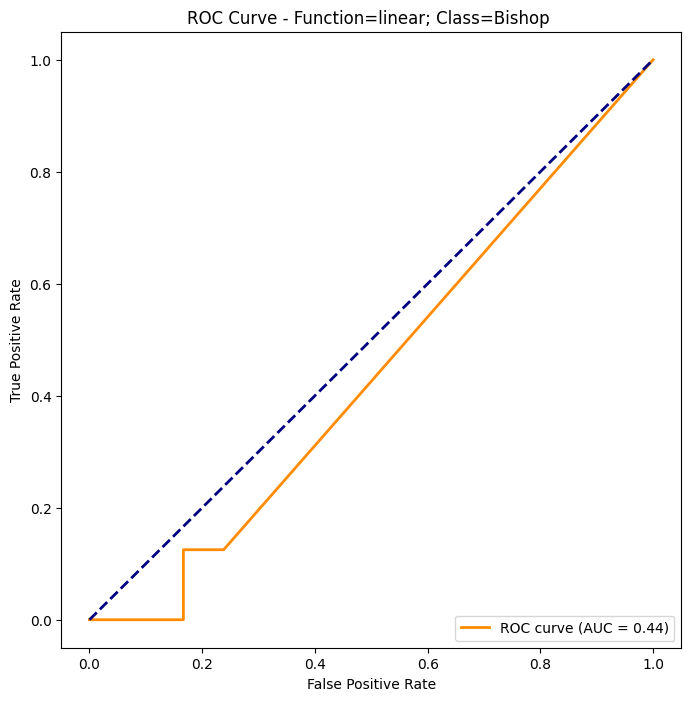

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


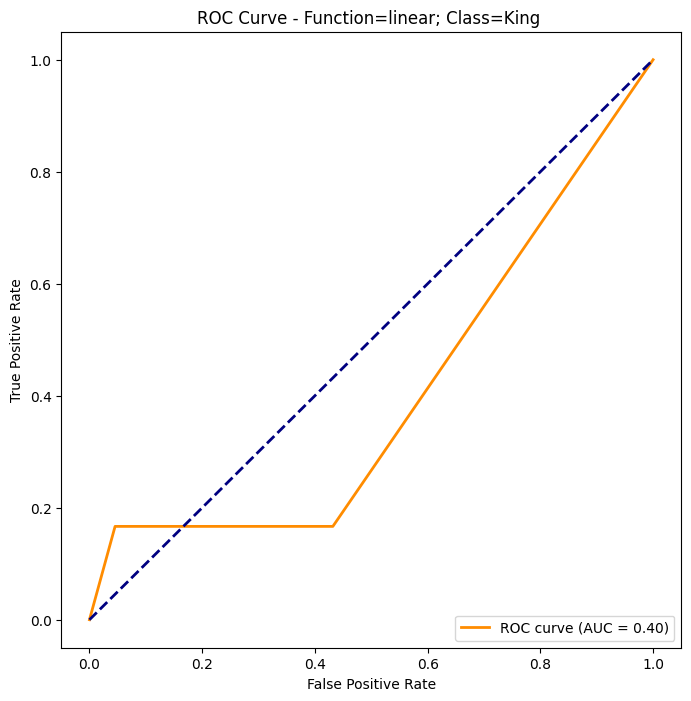

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


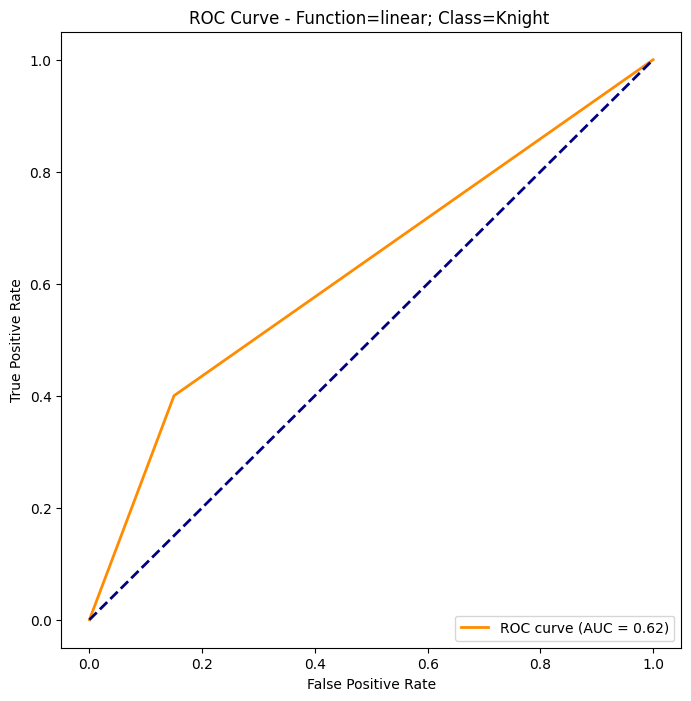

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


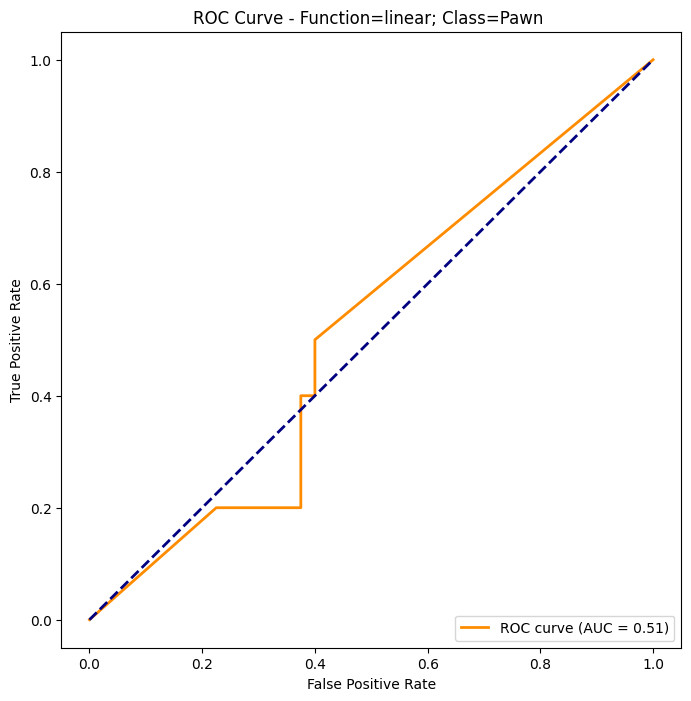

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


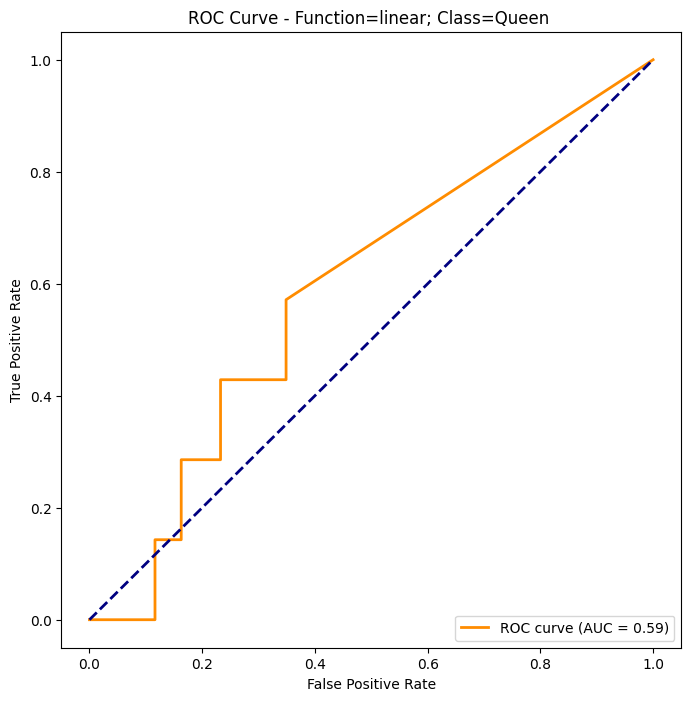

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


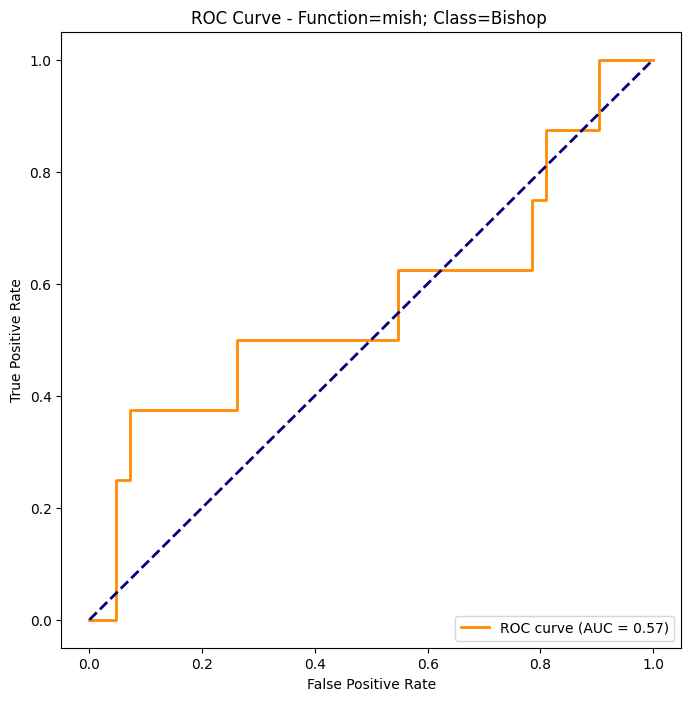

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


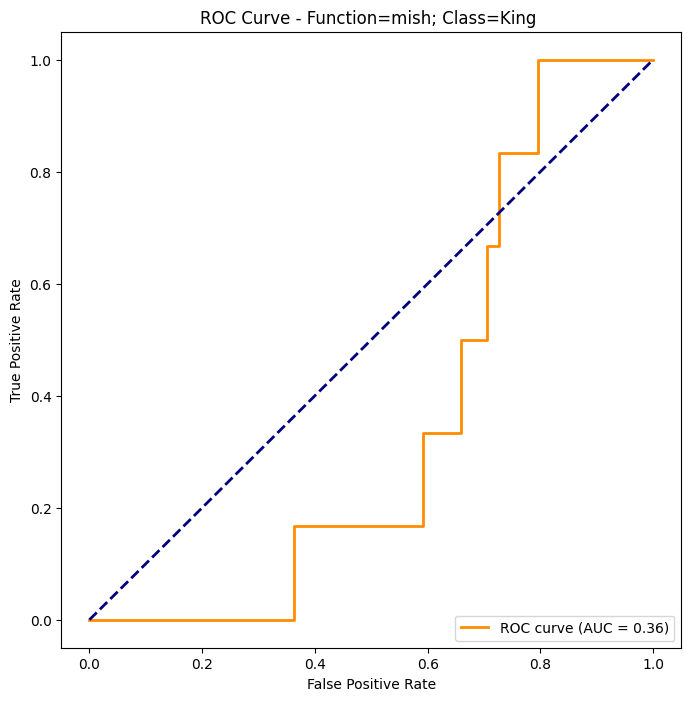

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


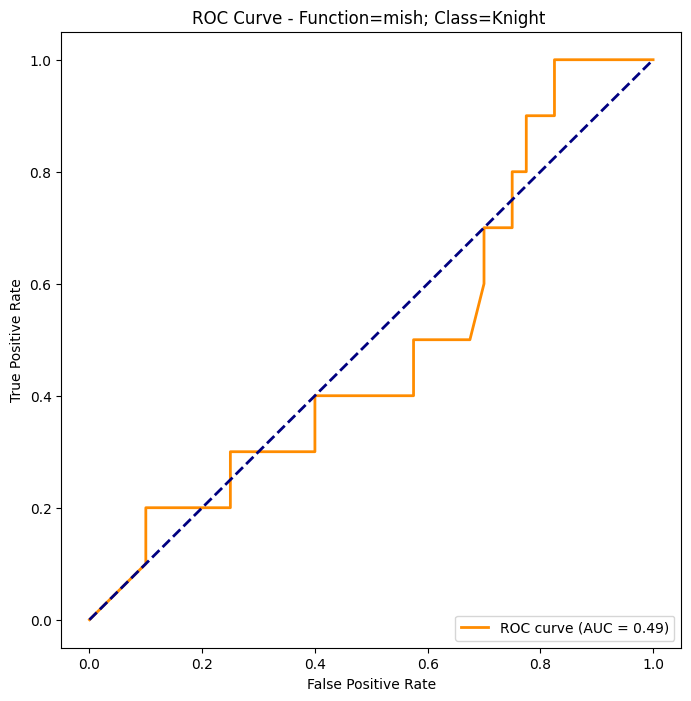

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


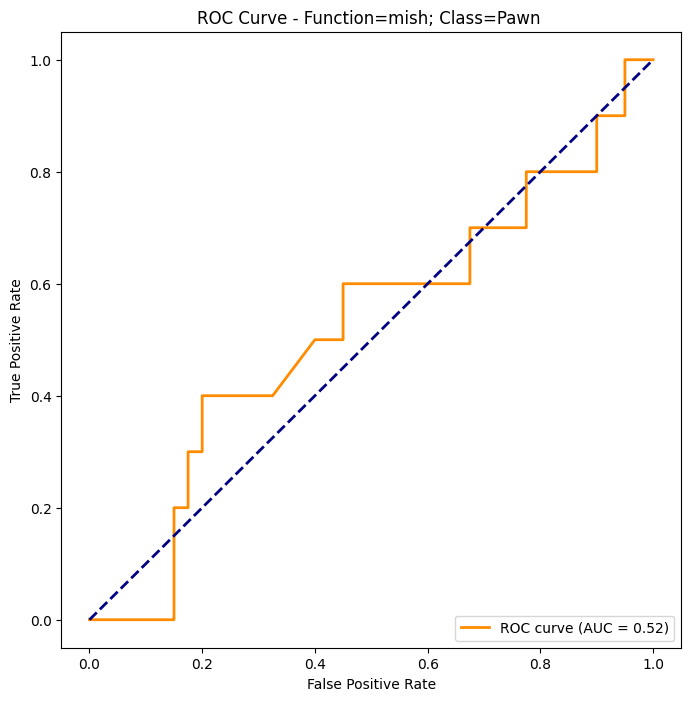

<ipython-input-30-4c8b1f9ab836>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))


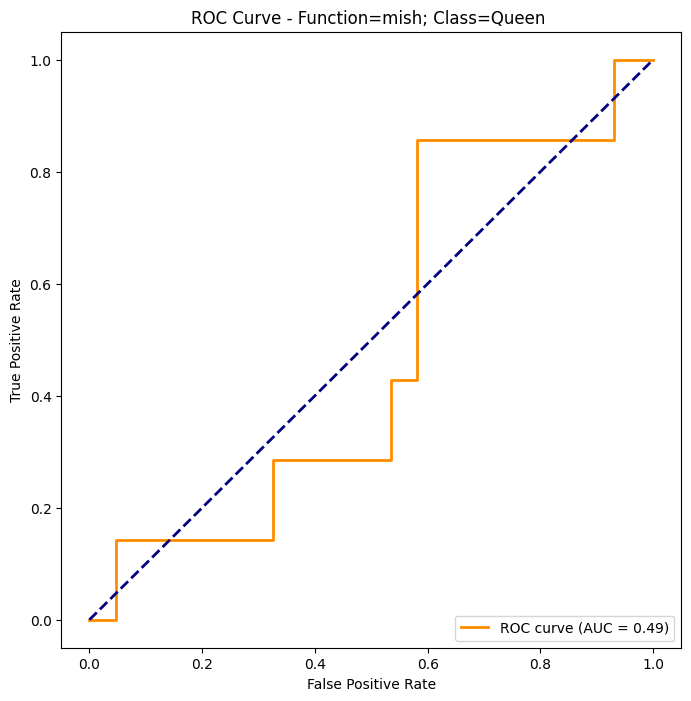

In [ ]:
from sklearn.metrics import roc_curve, auc

ranking = []

for model in models:
  auc_sum = 0.0
  for target_class in range(5):
    y_prob = model[1].predict_generator(val_data_gen, steps=len(val_data_gen))

    # Assuming num_classes is the number of classes in your problem
    num_classes = len(val_data_gen.class_indices)

    # Convert labels to binary format for the chosen class
    y_true = (val_data_gen.labels == target_class).astype(int)
    y_prob_target_class = y_prob[:, target_class]

    # Compute ROC curve and AUC
    try:
      fpr, tpr, thresholds = roc_curve(y_true, y_prob_target_class)
      roc_auc = auc(fpr, tpr)
      auc_sum += roc_auc
      # Visualize ROC curve
      plt.figure(figsize=(8, 8))
      plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'ROC Curve - Function={model[0]}; Class={get_class_name(target_class)} ')
      plt.legend(loc='lower right')
      plt.show()
    except:
      print("Input contained NaN")
      auc_sum += 0.0

  ranking.append((model[0], auc_sum/5, model[1]))

# Task 7: Evaluate best model (experiment on test set later)

In [ ]:
ranking = sorted(ranking, key=lambda tup: tup[1], reverse=True)
ranking

[('sigmoid',
  0.5609061210107722,
  <keras.src.engine.sequential.Sequential at 0x7c1cf04b65c0>),
 ('tanh',
  0.5554275646833785,
  <keras.src.engine.sequential.Sequential at 0x7c1c8655e320>),
 ('linear',
  0.5125322158461694,
  <keras.src.engine.sequential.Sequential at 0x7c1c10388820>),
 ('hard_sigmoid',
  0.508920819490587,
  <keras.src.engine.sequential.Sequential at 0x7c1c186789d0>),
 ('mish',
  0.4847393536695862,
  <keras.src.engine.sequential.Sequential at 0x7c1be43bf580>),
 ('relu',
  0.4844954193093728,
  <keras.src.engine.sequential.Sequential at 0x7c1cff4dce20>),
 ('elu',
  0.4787688261351052,
  <keras.src.engine.sequential.Sequential at 0x7c1c696d93c0>),
 ('silu',
  0.46065232054766947,
  <keras.src.engine.sequential.Sequential at 0x7c1c3055bb20>),
 ('leaky_relu',
  0.459843853820598,
  <keras.src.engine.sequential.Sequential at 0x7c1c6412ca00>),
 ('gelu',
  0.4338959277156952,
  <keras.src.engine.sequential.Sequential at 0x7c1c286473d0>),
 ('selu',
  0.4200096899224806,
 

# Task 8: Store model, load model

In [ ]:
ranking[0][2].save('chess_model_resnet_50.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
new_model = tf.keras.models.load_model('chess_model_resnet_50.h5')

In [ ]:
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=False
)

# Task 7: Evaluate best model on test data set

In [ ]:
test_dir = data_dir + "Chess_Test"

IMG_HEIGHT, IMG_WIDTH = 224, 224
batch_size = 32

test_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 32 images belonging to 6 classes.


In [ ]:
pred = new_model.predict(test_data_gen)

1/1 [==============================] - 2s 2s/step


In [ ]:
predicted_classes = tf.argmax(pred, axis=1).numpy()
predicted_classes

array([1, 1, 1, 5, 5, 3, 3, 3, 5, 5, 4, 4, 1, 1, 2, 1, 2, 3, 5, 3, 1, 2,
       1, 1, 3, 3, 4, 1, 2, 3, 3, 0])

In [ ]:
true_classes = test_data_gen.classes
true_classes

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 5, 5, 5, 5, 5], dtype=int32)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(len(predicted_classes)):
    print('Actual class: ' + get_class_name(true_classes[i]) + ', Predicted class: '
          + get_class_name(predicted_classes[i]))

Actual class: Bishop, Predicted class: King
Actual class: Bishop, Predicted class: King
Actual class: Bishop, Predicted class: King
Actual class: Bishop, Predicted class: Rook
Actual class: Bishop, Predicted class: Rook
Actual class: King, Predicted class: Pawn
Actual class: King, Predicted class: Pawn
Actual class: King, Predicted class: Pawn
Actual class: King, Predicted class: Rook
Actual class: King, Predicted class: Rook
Actual class: King, Predicted class: Queen
Actual class: King, Predicted class: Queen
Actual class: Knight, Predicted class: King
Actual class: Knight, Predicted class: King
Actual class: Knight, Predicted class: Knight
Actual class: Knight, Predicted class: King
Actual class: Knight, Predicted class: Knight
Actual class: Pawn, Predicted class: Pawn
Actual class: Pawn, Predicted class: Rook
Actual class: Pawn, Predicted class: Pawn
Actual class: Pawn, Predicted class: King
Actual class: Pawn, Predicted class: Knight
Actual class: Queen, Predicted class: King
Actua